# 클러스터링

- 특성 공간상에서 거리가 가까운 (유사한) 샘플들을 묶는 것(군집화)
- 거리기반 클러스터링(kMeans)과 밀도기반 클러스터링(DBSCAN) 두가지가 있다

# 데이터
- 지자체별 전력 사용량(용도별)을 기반으로 지자체 클러스터링 수행

## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 14})

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples, silhouette_score

## 한글 설치

### 코랩에 한글 폰트 설치
- (주의!) 아래 셀을 한 번 실행 후에, 런타임 - 런타임 다시 시작을 실행하고 아래 셀을 한번 더 실행하여야 한다

In [3]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
 
# !apt -qq -y install fonts-nanum
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

### 한글 설정

In [4]:
import platform, matplotlib
from matplotlib import rc

matplotlib.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    rc('font', family="Malgun Gothic")
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')

데이터 읽기
--

In [5]:
power_data = pd.read_excel('https://github.com/StillWork/data/blob/master/power.xls?raw=true')
print(power_data.shape)
power_data[:3]

(19, 28)


구분       주거용      공공용      서비스업     업무용합계     농림어업      광업       제조업  \
0  강원   1940933  1400421   6203749   7604170   607139  398287   6002286   
1  개성         0        0         0         0        0       0         0   
2  경기  16587710  5533662  33434551  38968213  2371347  317263  56603327   

     식료품제조    섬유,의류  ...     기타기계    사무기기     전기기기     영상,음향      자동차    기타운송  \
0   546621    13027  ...    35063    2019    38062     43986   113448  108629   
1        0        0  ...        0       0        0         0        0       0   
2  2544420  2109963  ...  3613798  317244  1040171  24519644  2977165   67594   

     가구및기타    재생재료     산업용합계         합계  
0    12872    3418   7007712   16552816  
1        0       0         0          0  
2  1833112  133041  59291937  114847859  

[3 rows x 28 columns]

In [6]:
df = power_data.set_index('구분')
df = df.drop(['합계', '개성'])
df = df.drop('합계', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 강원 to 충북
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   주거용     17 non-null     int64
 1   공공용     17 non-null     int64
 2   서비스업    17 non-null     int64
 3   업무용합계   17 non-null     int64
 4   농림어업    17 non-null     int64
 5   광업      17 non-null     int64
 6   제조업     17 non-null     int64
 7   식료품제조   17 non-null     int64
 8   섬유,의류   17 non-null     int64
 9   목재,나무   17 non-null     int64
 10  펄프,종이   17 non-null     int64
 11  출판,인쇄   17 non-null     int64
 12  석유,화확   17 non-null     int64
 13  의료,광학   17 non-null     int64
 14  요업      17 non-null     int64
 15  1차금속    17 non-null     int64
 16  조립금속    17 non-null     int64
 17  기타기계    17 non-null     int64
 18  사무기기    17 non-null     int64
 19  전기기기    17 non-null     int64
 20  영상,음향   17 non-null     int64
 21  자동차     17 non-null     int64
 22  기타운송    17 non-null     int64
 23  가구및기타   17 non-null  

<function matplotlib.pyplot.show(close=None, block=None)>

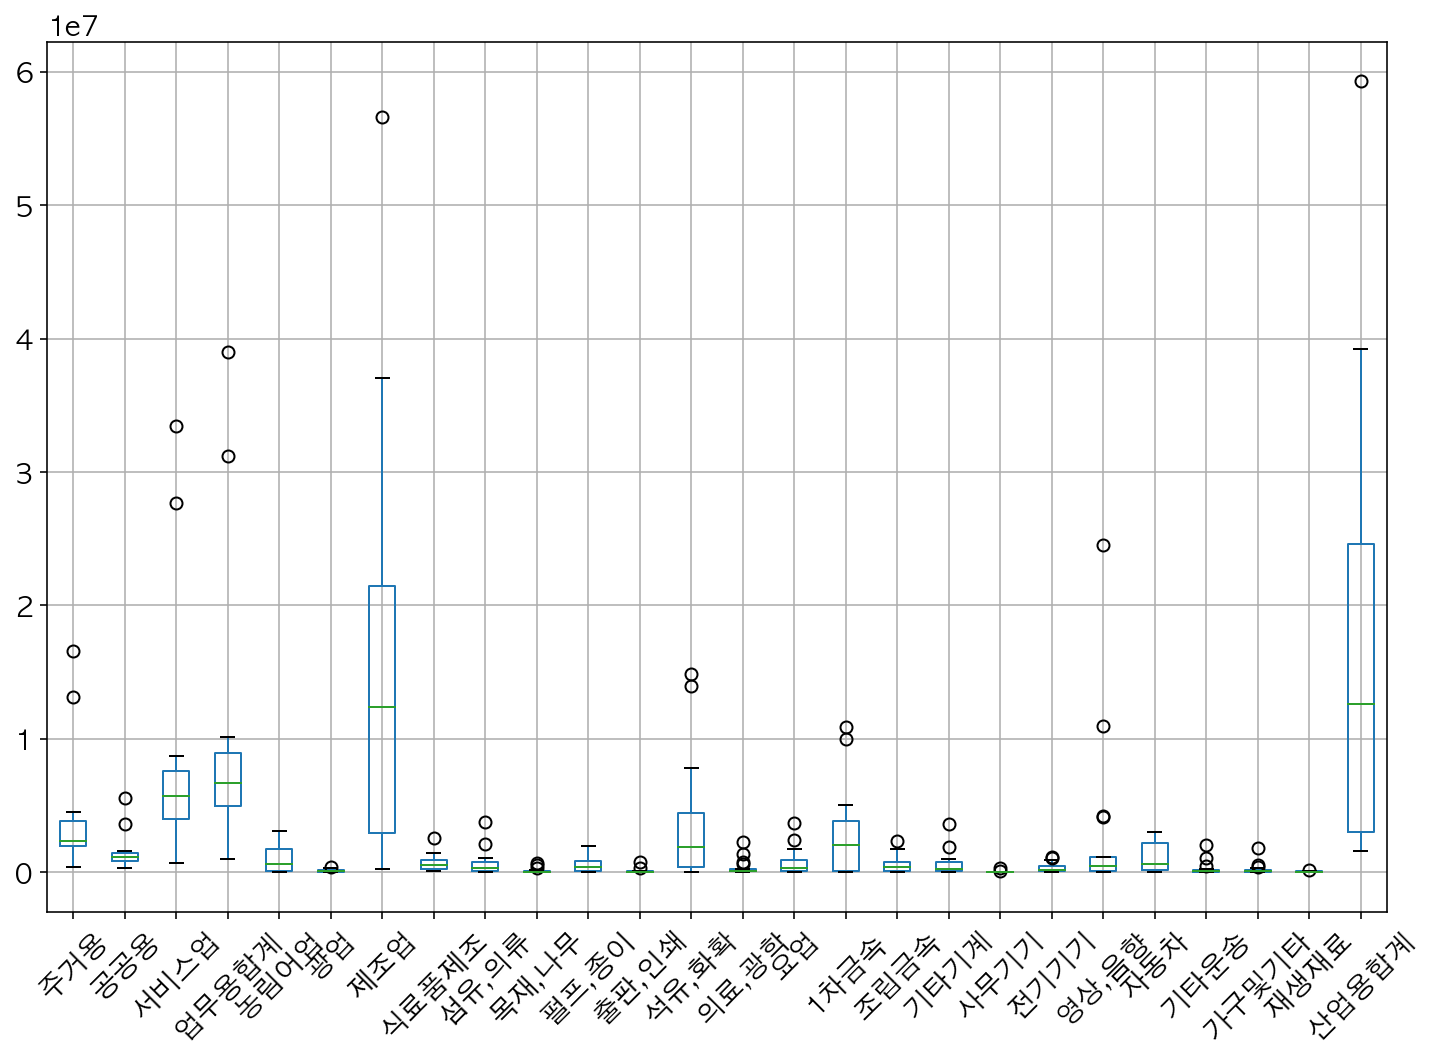

In [8]:
df.boxplot(figsize=(12,8))
plt.xticks(rotation=45)
plt.show

<AxesSubplot:ylabel='구분'>

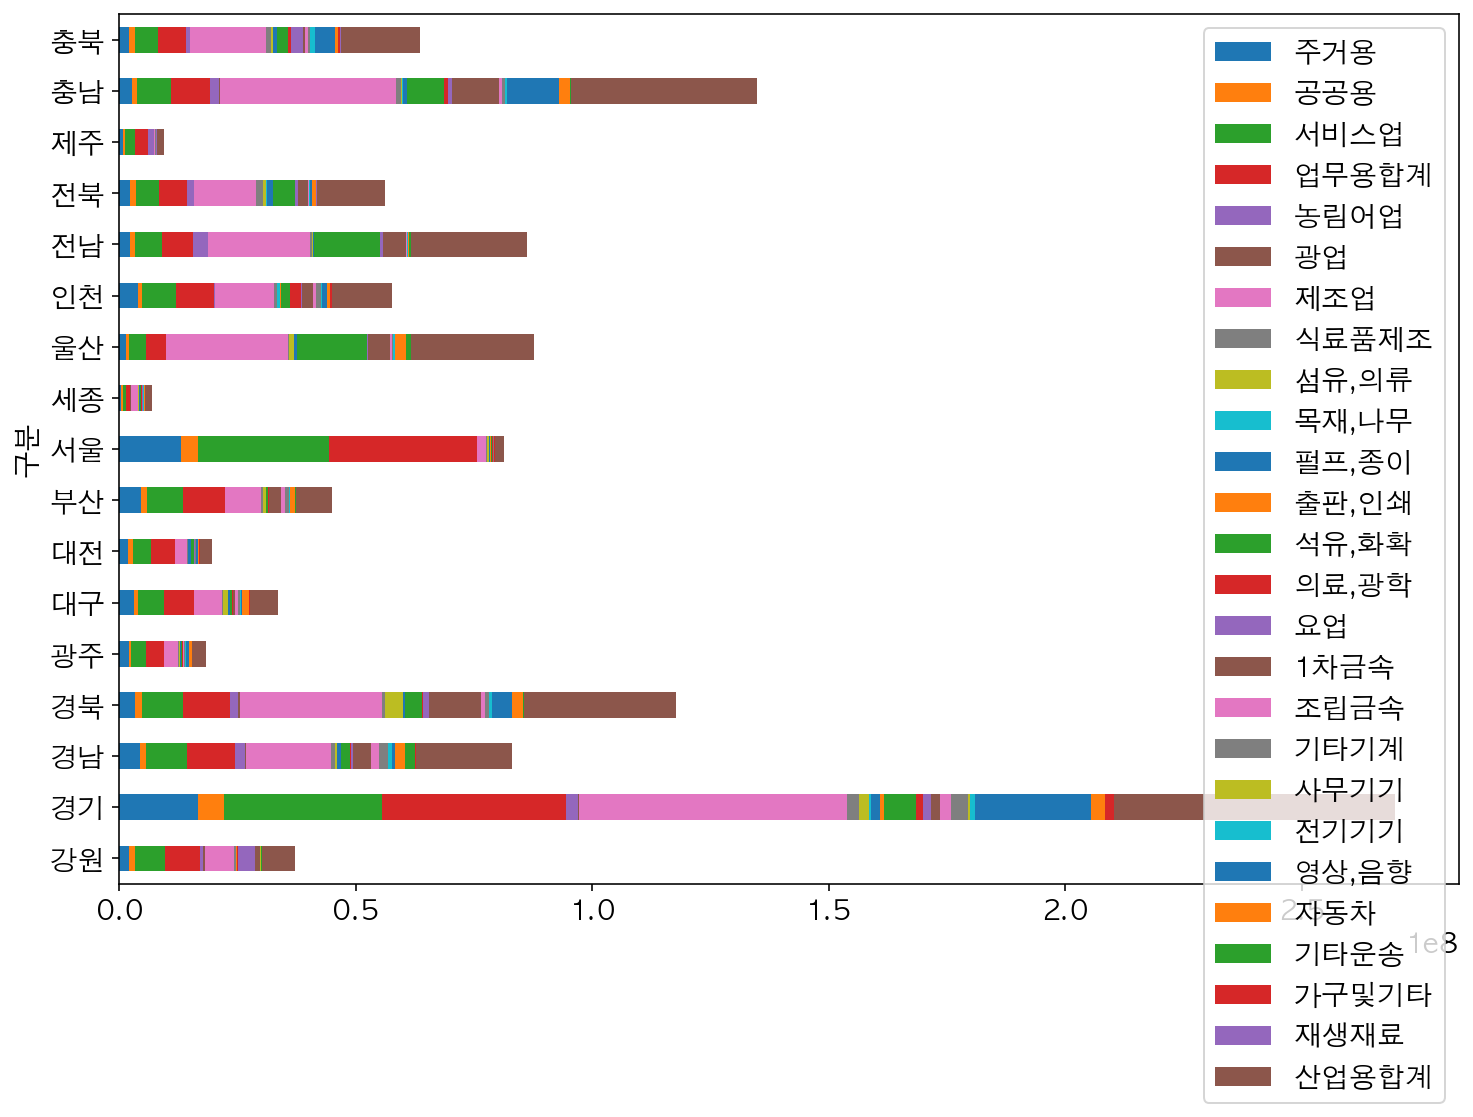

In [9]:
df.plot(kind='barh', figsize=(12,8), stacked=True)

<AxesSubplot:ylabel='구분'>

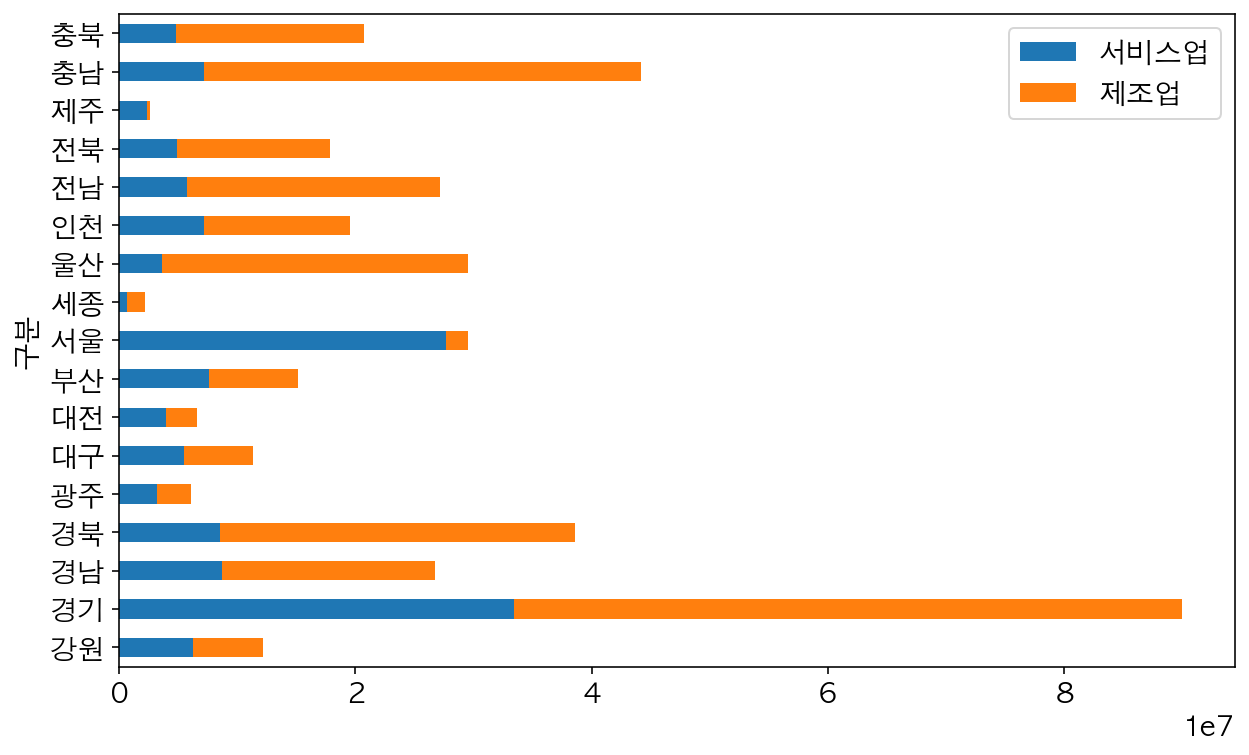

In [10]:
df = df[['서비스업', '제조업']]
df.plot(kind='barh', figsize=(10,6), stacked=True)

In [11]:
df.head(5)

서비스업       제조업
구분                    
강원   6203749   6002286
경기  33434551  56603327
경남   8667737  18053778
경북   8487402  30115601
광주   3174973   2910768

데이터 탐색

In [12]:
df.index

Index(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천',
       '전남', '전북', '제주', '충남', '충북'],
      dtype='object', name='구분')

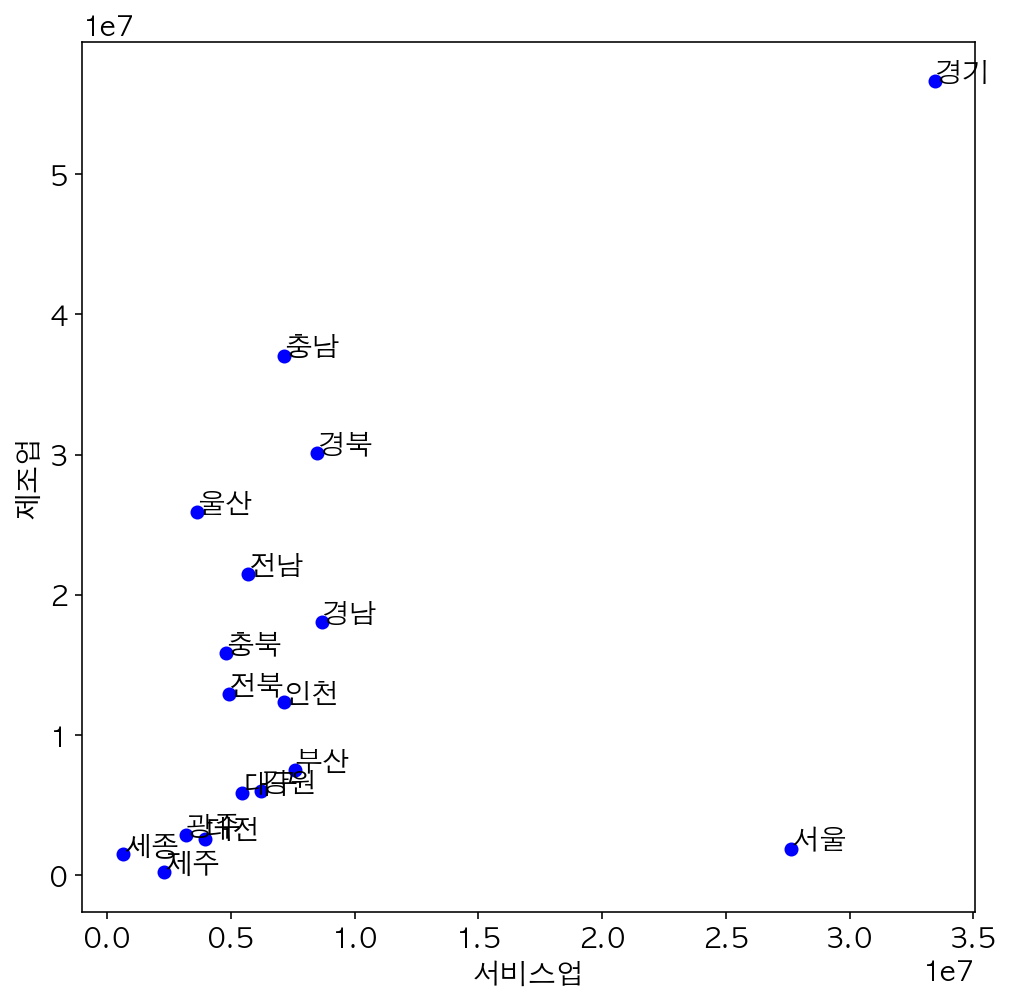

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(df['서비스업'], df['제조업'],c='b',marker='o')
plt.xlabel('서비스업')
plt.ylabel('제조업')

for n in range(df.shape[0]):
    plt.text(df['서비스업'][n], df['제조업'][n], df.index[n])

## 이상치 처리

In [14]:
df = df.drop(['경기', '서울'])

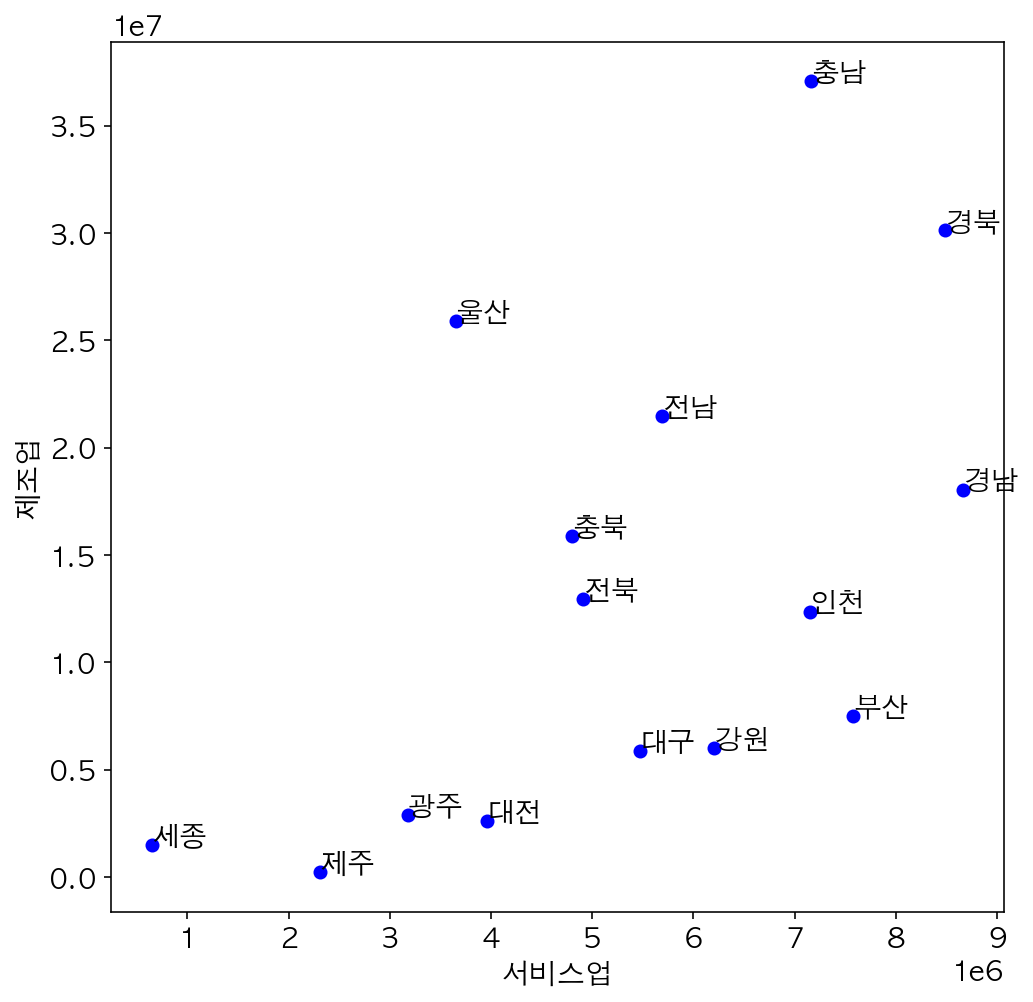

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(df['서비스업'], df['제조업'],c='b',marker='o')
plt.xlabel('서비스업')
plt.ylabel('제조업')

for n in range(df.shape[0]):
    plt.text(df['서비스업'][n], df['제조업'][n], df.index[n])

# kMeans 클러스터링 모델

## 두개의 특성만 사용

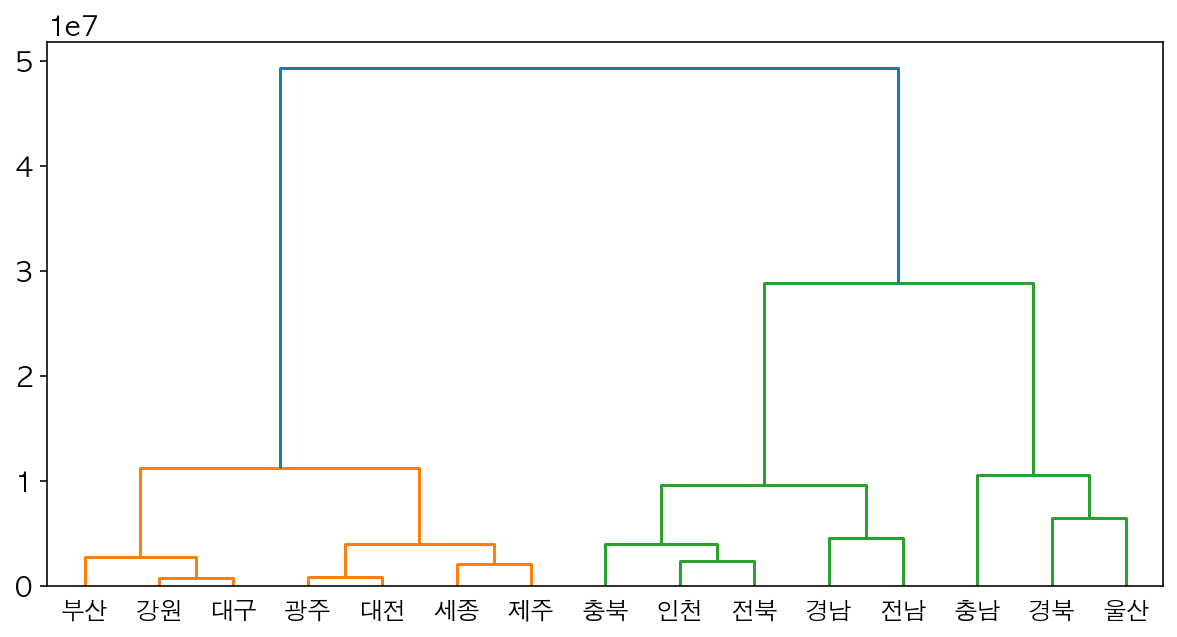

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
link_dist = linkage(df, metric='euclidean', method='ward')  
dendrogram(link_dist, labels=df.index.tolist())
plt.show()

In [17]:
from sklearn.cluster import KMeans
k = KMeans(n_clusters=3)
k.fit(df)
k.labels_

array([0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2], dtype=int32)

In [18]:
df['클러스터'] = k.labels_
df.head(10)

서비스업       제조업  클러스터
구분                         
강원  6203749   6002286     0
경남  8667737  18053778     2
경북  8487402  30115601     1
광주  3174973   2910768     0
대구  5470438   5862633     0
대전  3955921   2608343     0
부산  7582169   7512588     0
세종   645424   1502922     0
울산  3649386  25883132     1
인천  7154416  12367816     2

In [19]:
df.drop('클러스터', axis = 1, inplace=True) ; df.head()

서비스업       제조업
구분                   
강원  6203749   6002286
경남  8667737  18053778
경북  8487402  30115601
광주  3174973   2910768
대구  5470438   5862633

In [20]:
centers = k.cluster_centers_ ; centers

array([[ 4191629.42857143,  3805868.14285714],
       [ 6433742.33333333, 31018896.        ],
       [ 6245553.6       , 16144968.6       ]])

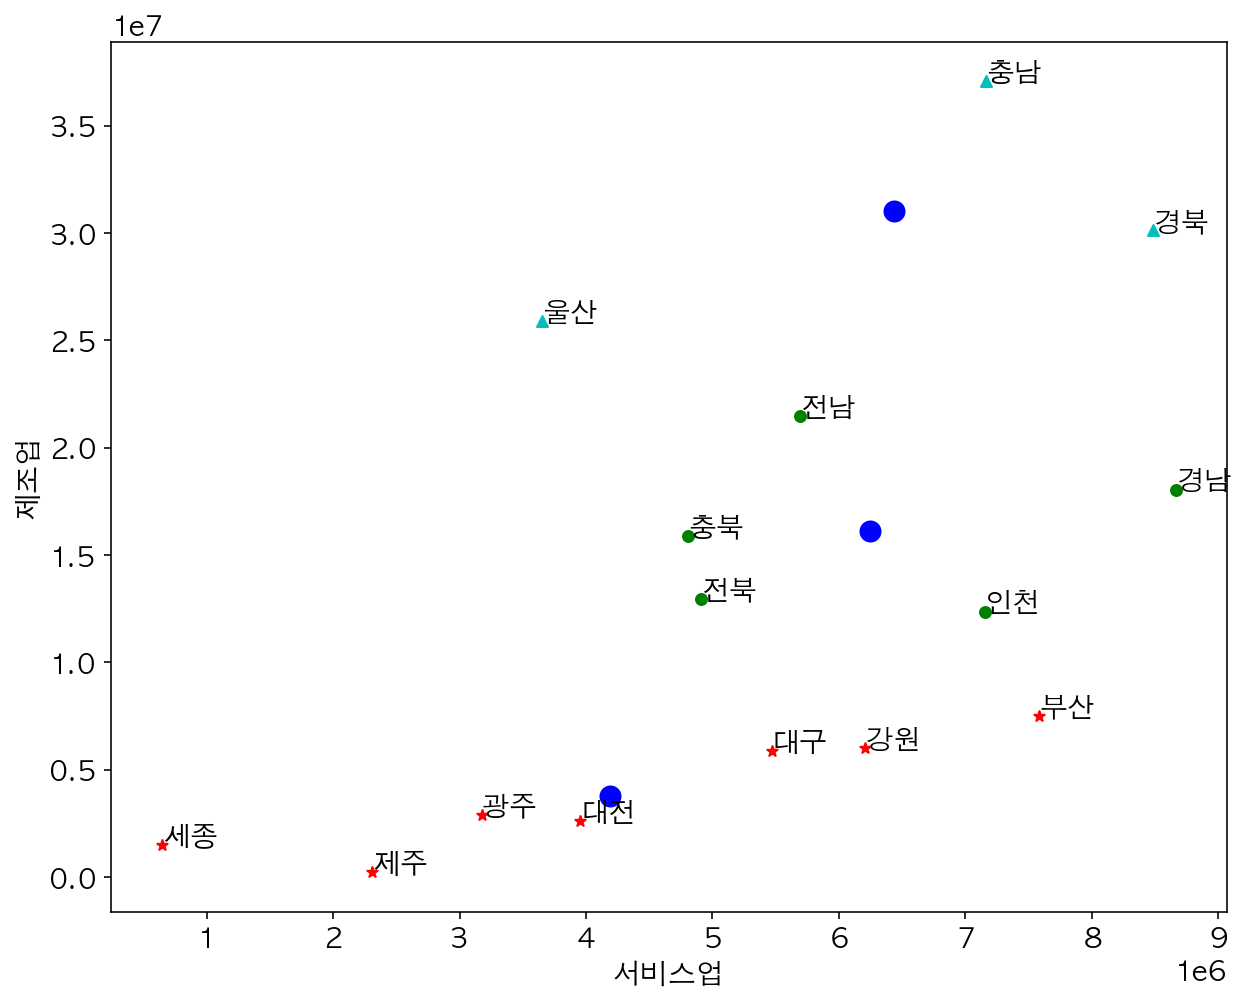

In [21]:
my_markers=['*','^', 'o','^','.',',','1','2']
my_color =['r','c','g','b','k','y','r','y']

plt.figure(figsize=(10, 8))
plt.xlabel('서비스업')
plt.ylabel('제조업')
for n in range(df.shape[0]):
    label = k.labels_[n]
    plt.scatter(df['서비스업'][n], df['제조업'][n], c=my_color[label], marker=my_markers[label], s=30)
    plt.text(df['서비스업'][n], df['제조업'][n], df.index[n])
    
for i in range(k.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c = 'b', s= 100)

## (연습) 전력 데이터를 스케일링 한 후 클러스터링 수행
- 표준 스케일링을 적용한 후 클러스터링을 다시 수행하시오

In [22]:
scaler = StandardScaler()
df.loc[:,['서비스업', '제조업']] = scaler.fit_transform(df.copy()[['서비스업', '제조업']])

<function matplotlib.pyplot.show(close=None, block=None)>

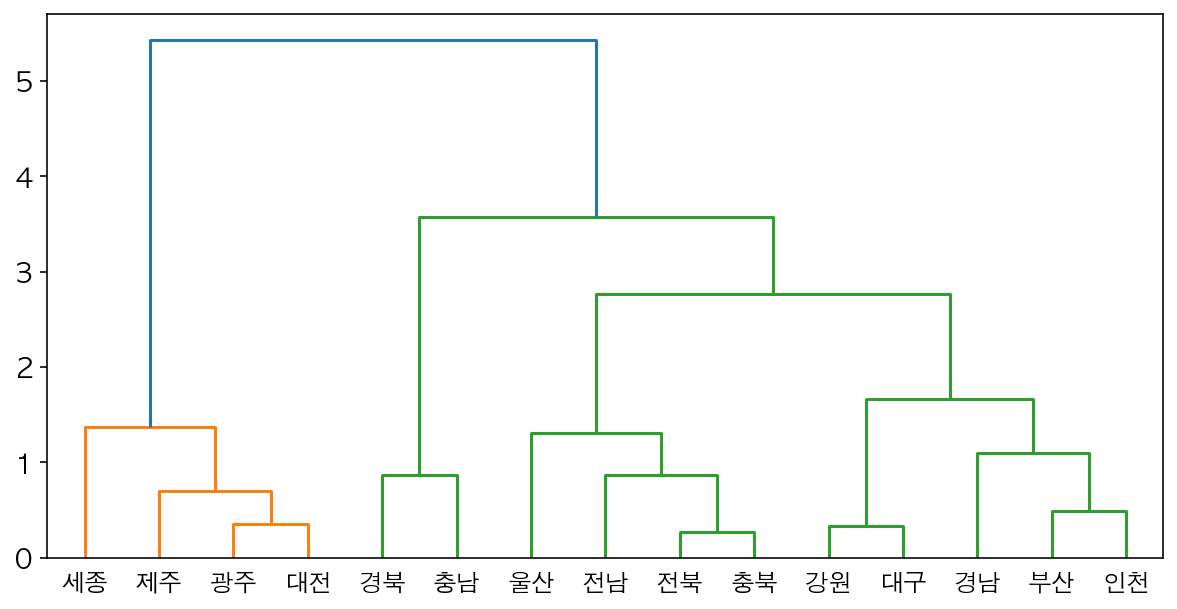

In [23]:
Z = linkage(df, metric='euclidean', method='ward') 
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=df.index.tolist())
plt.show

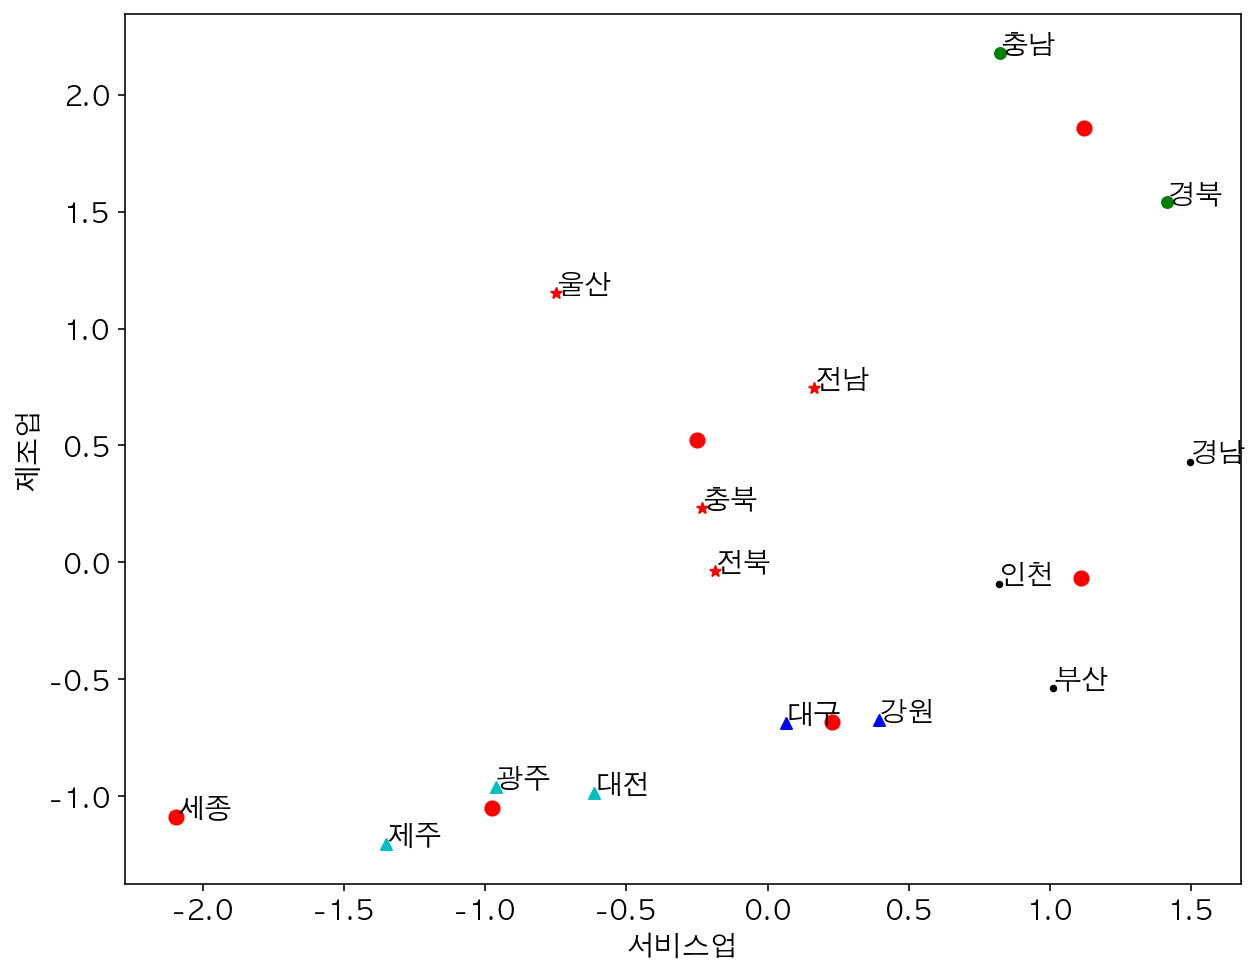

In [24]:
k = KMeans(n_clusters= 6).fit(df)
centers = k.cluster_centers_ 

plt.figure(figsize=(10, 8))
plt.xlabel('서비스업')
plt.ylabel('제조업')

for n in range(df.shape[0]):
    label = k.labels_[n]
    plt.scatter(df['서비스업'][n], df['제조업'][n], c=my_color[label], marker=my_markers[label], s=30)
    plt.text(df['서비스업'][n], df['제조업'][n], df.index[n])
    
for i in range(k.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c = 'r', s= 50)

## 모든 특성 고려

In [25]:
power_data[:3]

구분       주거용      공공용      서비스업     업무용합계     농림어업      광업       제조업  \
0  강원   1940933  1400421   6203749   7604170   607139  398287   6002286   
1  개성         0        0         0         0        0       0         0   
2  경기  16587710  5533662  33434551  38968213  2371347  317263  56603327   

     식료품제조    섬유,의류  ...     기타기계    사무기기     전기기기     영상,음향      자동차    기타운송  \
0   546621    13027  ...    35063    2019    38062     43986   113448  108629   
1        0        0  ...        0       0        0         0        0       0   
2  2544420  2109963  ...  3613798  317244  1040171  24519644  2977165   67594   

     가구및기타    재생재료     산업용합계         합계  
0    12872    3418   7007712   16552816  
1        0       0         0          0  
2  1833112  133041  59291937  114847859  

[3 rows x 28 columns]

In [26]:
df = power_data.set_index('구분')
df.drop(['업무용합계', '산업용합계', '합계'], axis=1, 
           inplace=True, errors='ignore')
df.drop(['합계','개성','경기','서울'], inplace=True,errors='ignore')
# df.drop(['합계','개성'], inplace=True,errors='ignore')

In [27]:
scaler = StandardScaler()
df_sc = scaler.fit_transform(df)
df_sc[:2]

array([[-0.44746058,  1.10736258,  0.39399187, -0.31615105,  2.74249597,
        -0.67628201, -0.05038302, -0.61638799, -0.4514398 , -1.06745713,
        -0.83444039, -0.7156478 , -0.38809246,  2.94806033, -0.54548247,
        -0.94835864, -0.82894054, -0.65669668, -0.83006166, -0.52717839,
        -0.97634592, -0.33618143, -0.55631841, -0.88611656],
       [ 1.57896143,  1.17653431,  1.49834892,  1.30563225,  0.00899358,
         0.43120029,  0.88597945, -0.25131566, -0.19991305,  1.02864794,
         0.19147769, -0.35756084, -0.2208235 , -0.29151019,  0.27268778,
         2.64991989,  2.89524796, -0.22275393,  1.80996346, -0.35469471,
         1.28912118,  3.27934154,  1.11033629,  0.67733169]])

<function matplotlib.pyplot.show(close=None, block=None)>

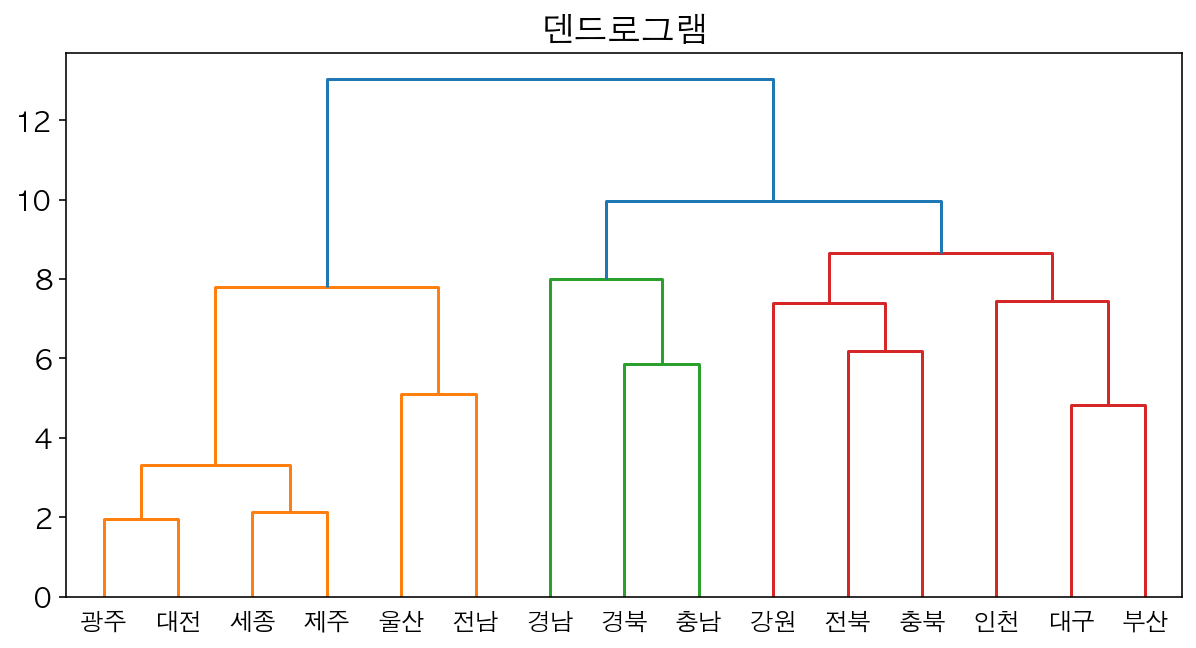

In [28]:
Z = linkage(df_sc, metric='euclidean', method='ward') 
plt.figure(figsize=(10, 5))
plt.title('덴드로그램')
dendrogram(Z, labels=df.index.tolist())
plt.show

In [29]:
k = KMeans(n_clusters= 6).fit(df_sc)
centers = k.cluster_centers_ ; centers[:2]

array([[-1.05197991, -1.11013559, -1.25649503, -0.55151969, -0.77622442,
        -1.06099427, -0.99314457, -0.51810481, -0.54749103, -0.50241786,
        -0.69401233, -0.68377274, -0.46963477, -0.61813549, -0.84005063,
        -0.9036343 , -0.74723459, -0.38491771, -0.67939734, -0.42225938,
        -0.87754448, -0.53345167, -0.55559073, -0.8156635 ],
       [-0.241505  ,  0.55079002, -0.20940549,  0.17094011,  0.15899812,
         0.09769949,  1.79028285, -0.04822616,  0.48417922,  1.72565639,
        -0.36499601, -0.03225107,  0.04087855,  0.79270215, -0.46425144,
        -0.08435241, -0.37390306,  0.28555647,  0.92719194,  0.25321607,
        -0.29081235, -0.39561526,  1.12579108,  1.55575539]])

# 산포도 그리기

- 2차원 PCA를 사용해서 그린다
- PCA: 특성의 수를 정보를 잃지 않으면서 차원을 줄이는 기법

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-10-04%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%209.24.09.png?raw=1" align='left'  width=300>

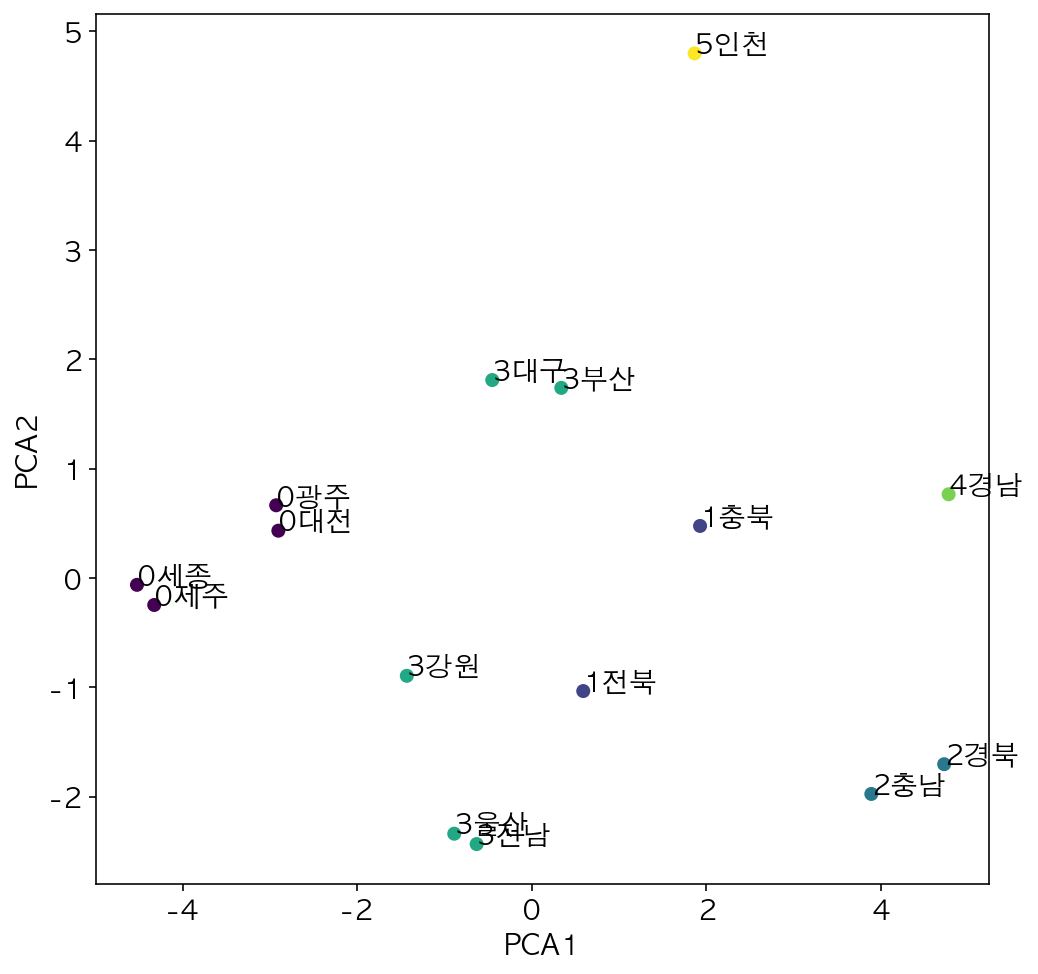

In [30]:
pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(df_sc)
plt.figure(figsize=(8,8))
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=k.labels_)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
for n in range(df.shape[0]):
    plt.text(X_pca2[:,0][n], X_pca2[:,1][n], str(k.labels_[n])+df.index[n])

## (연습) 서울과 경기를 포함하여 PCA-2 산포도를 그려보시오

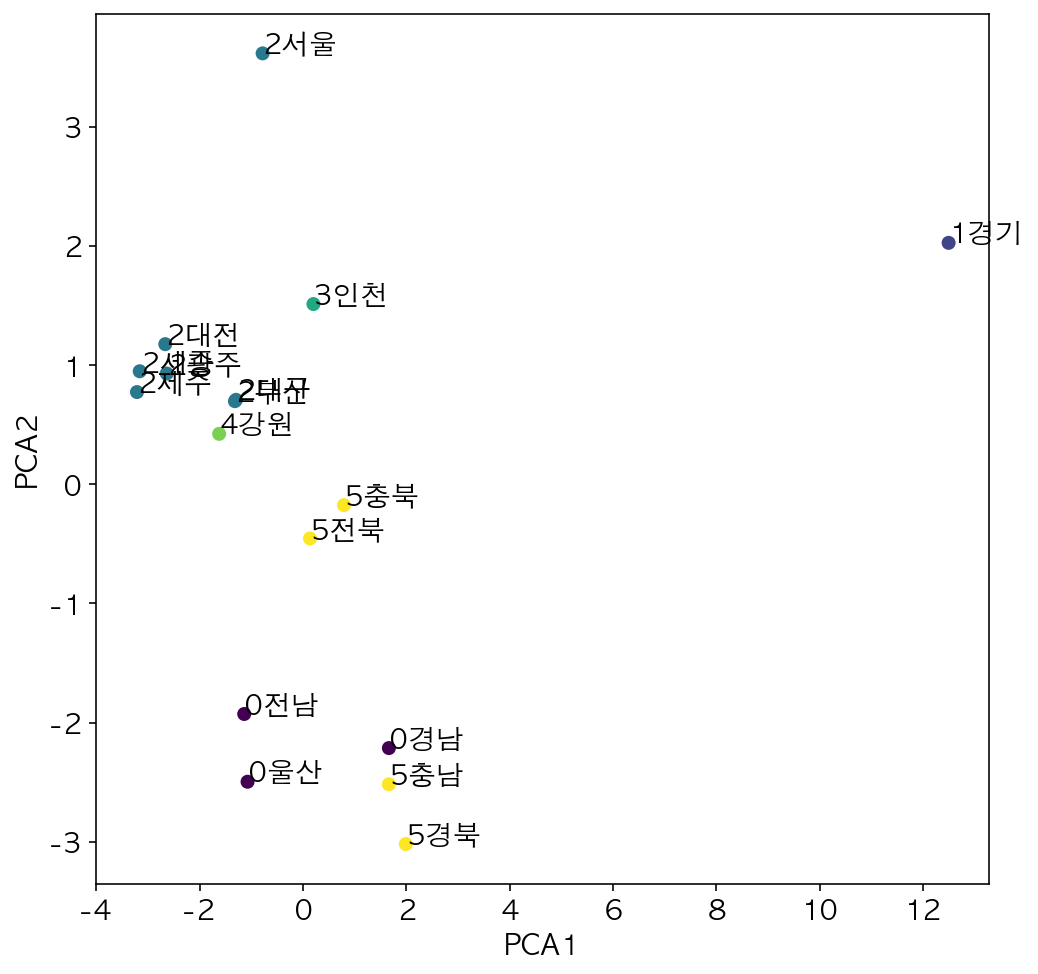

In [31]:
df = power_data.set_index('구분')
df.drop(['업무용합계', '산업용합계', '합계'], axis=1, 
           inplace=True, errors='ignore')
# df.drop(['합계','개성','경기','서울'], inplace=True,errors='ignore')
df.drop(['합계','개성'], inplace=True,errors='ignore')

df_sc = scaler.fit_transform(df)
k = KMeans(n_clusters= 6).fit(df_sc)

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(df_sc)
plt.figure(figsize=(8,8))
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=k.labels_)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
for n in range(df.shape[0]):
    plt.text(X_pca2[:,0][n], X_pca2[:,1][n], str(k.labels_[n])+df.index[n])

## 최적의 k 찾기

- 실루엣 지수 사용
- knee 포인트 찾기: 클러스터 갯수에 따른 무게(inertia) 변화가 큰 곳 찾기

### 실루엣 지수 보기

<img src=" https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-10-16%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%209.57.47.png?raw=1" align = 'left' width=400>

In [32]:
results = []
for i in range(2,12):
  cluster_labels = KMeans(n_clusters=i).fit_predict(df_sc)
  score = silhouette_score(df_sc, cluster_labels)
  results.append([i,score])
df_result = pd.DataFrame(results, columns=["n_clusters","silhouette_score"])
df_result.set_index('n_clusters', inplace=True)
df_result

silhouette_score
n_clusters                  
2                   0.572008
3                   0.204492
4                   0.184868
5                   0.190294
6                   0.198948
7                   0.220218
8                   0.223960
9                   0.234297
10                  0.219073
11                  0.204814

### knee 포인트 찾기

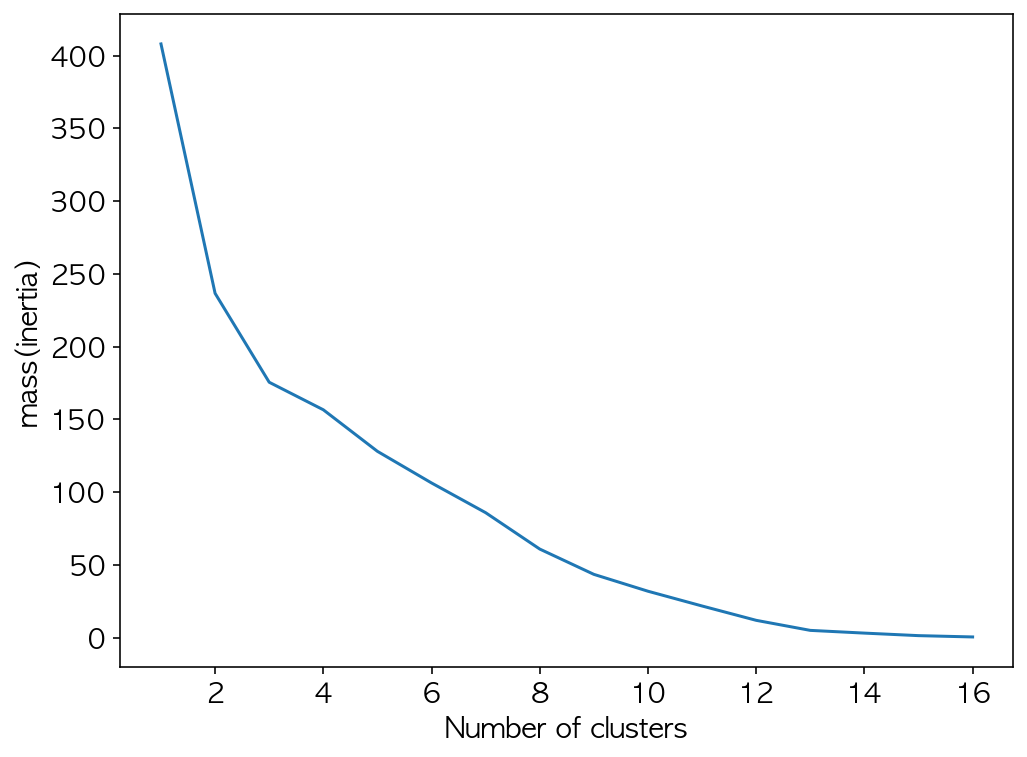

In [33]:
mass = []
N = len(df_sc)
for i in range(1, N):
    kmeans = KMeans(n_clusters = i).fit(df_sc)
    mass.append(kmeans.inertia_)
plt.plot(range(1, N), mass)
plt.xlabel('Number of clusters')
plt.ylabel('mass(inertia)')
plt.show()

# 밀도기반 클러스터링

- 샘플간 거리가 아니라 일정한 밀도를 유지하면 같은 클러스트로 구성하는 방법

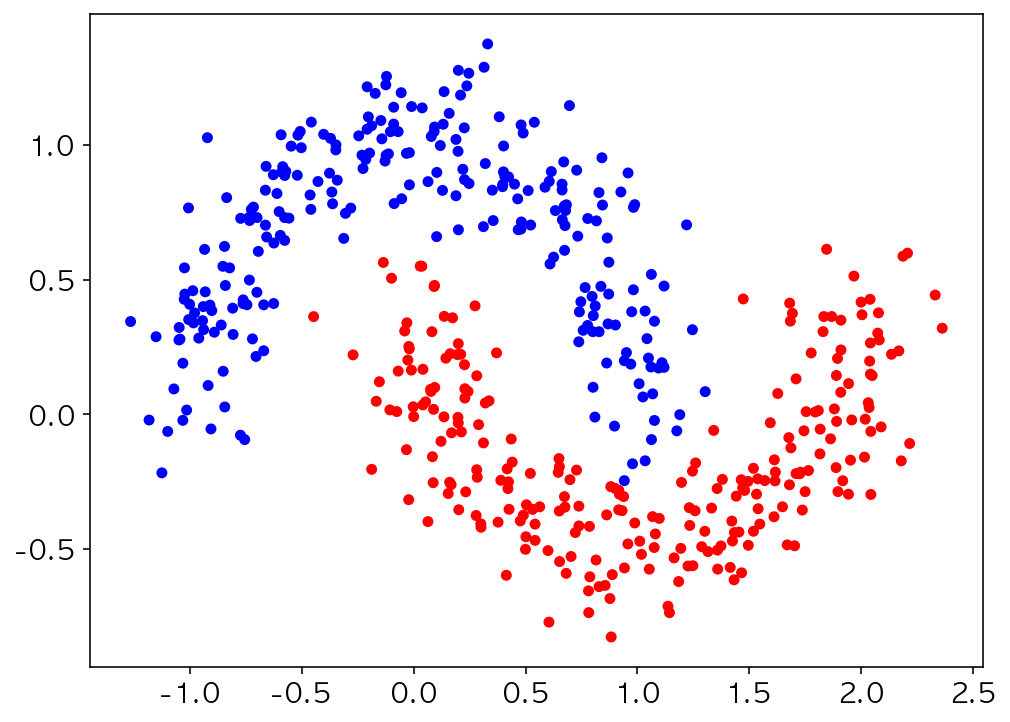

In [34]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
X, y = make_moons(n_samples=500, noise=0.15, random_state=11)
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='bwr')
plt.show()

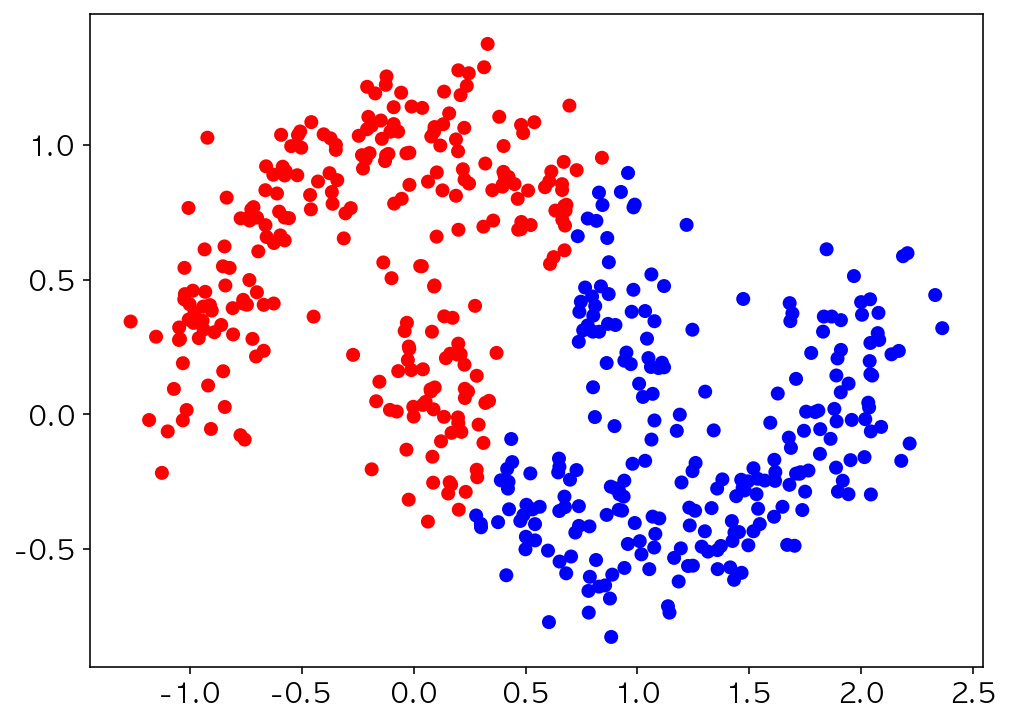

In [35]:
k = KMeans(n_clusters=2).fit(X)
plt.scatter(X[:,0], X[:,1],c=k.labels_, cmap='bwr')

## DBSCAN 사용

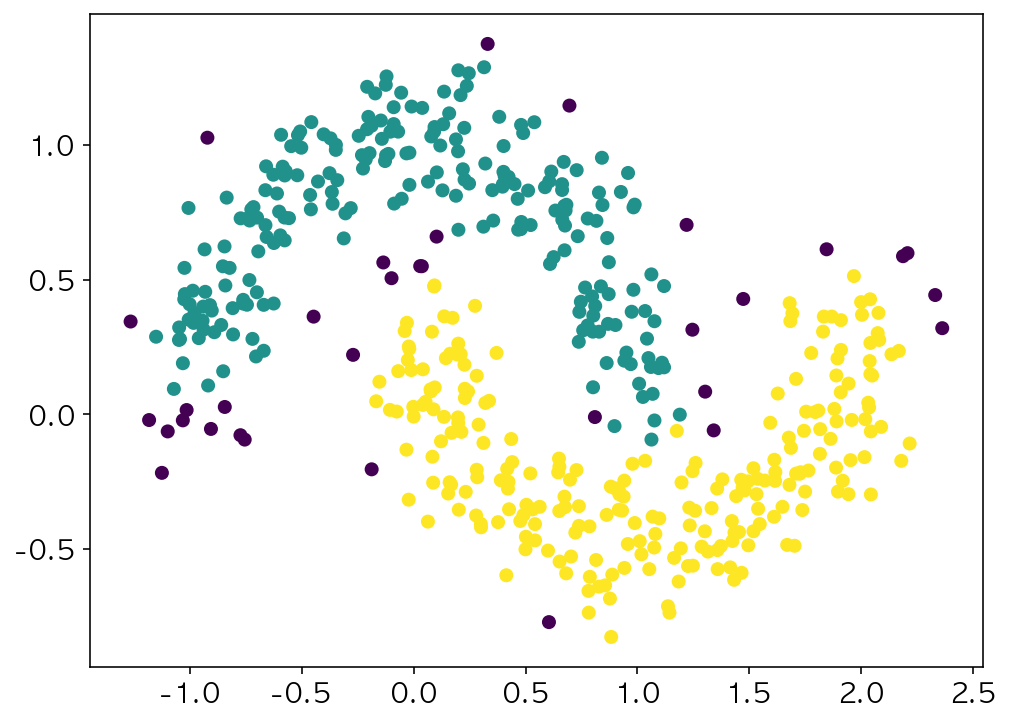

In [36]:
dbscan = DBSCAN(eps=0.17, min_samples=9, metric='euclidean')
dbscan.fit(X)
plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)

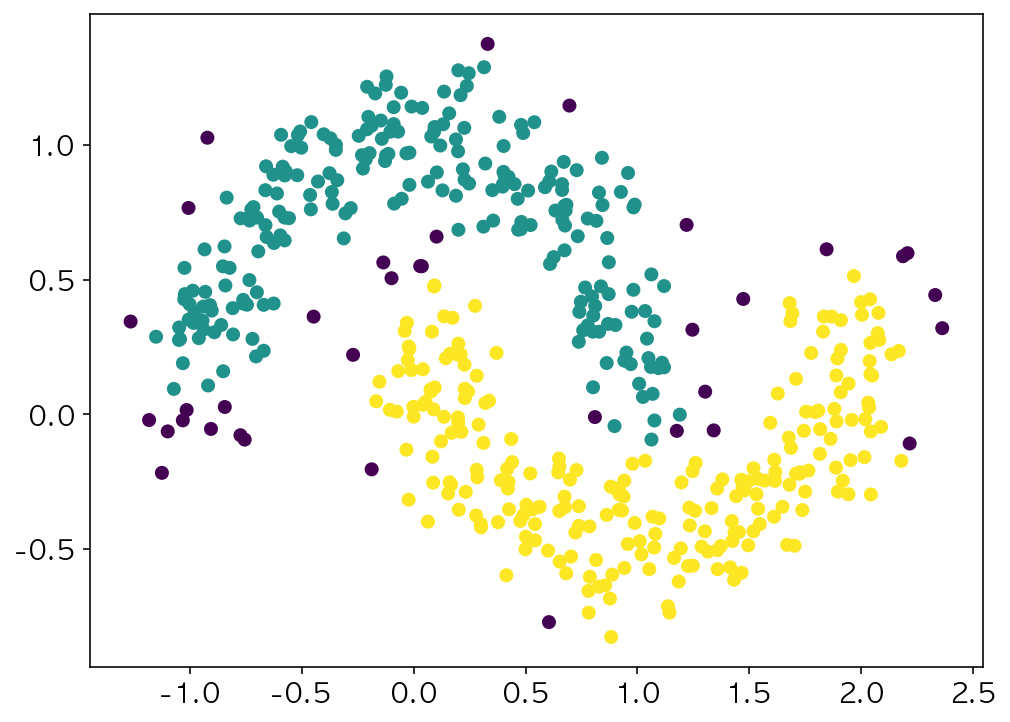

In [37]:
dbscan = DBSCAN(eps=0.17, min_samples=10, metric='euclidean')
dbscan.fit(X)
plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)

## (연습) two_moon 생성시 noise=0.2로 하고 가능한 두개의 클러스터를 찾아보시오
- 노이지가 많으면 클러스터 구분이 어려워진다
- 시행착오 방법으로 최적의 eps과 min_samples 값을 찾는 문제이다.


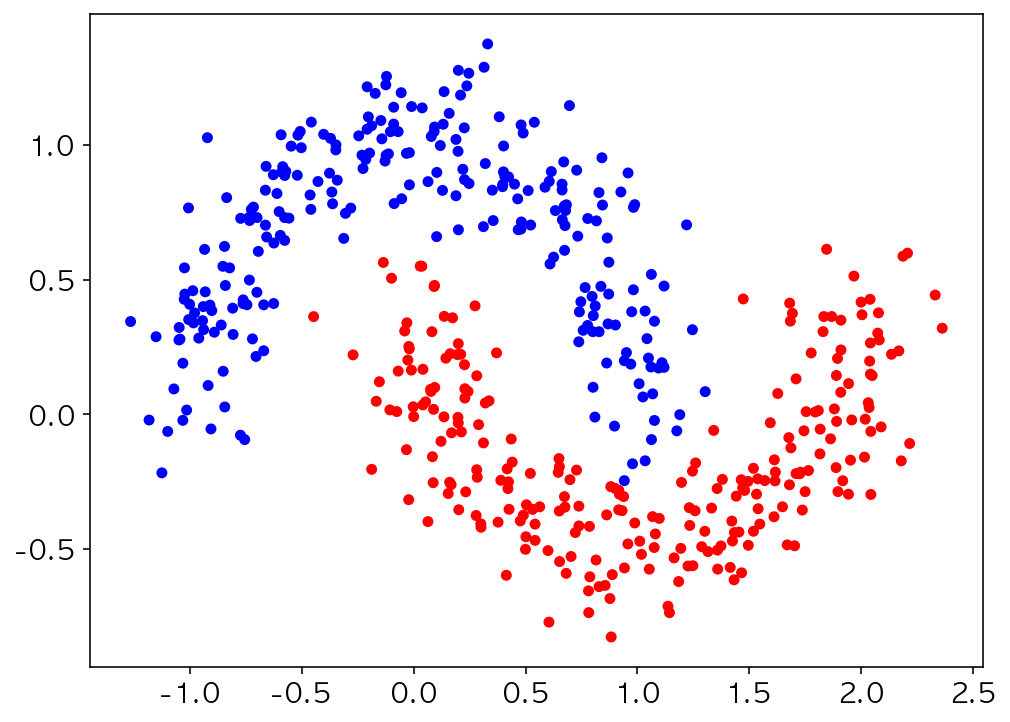

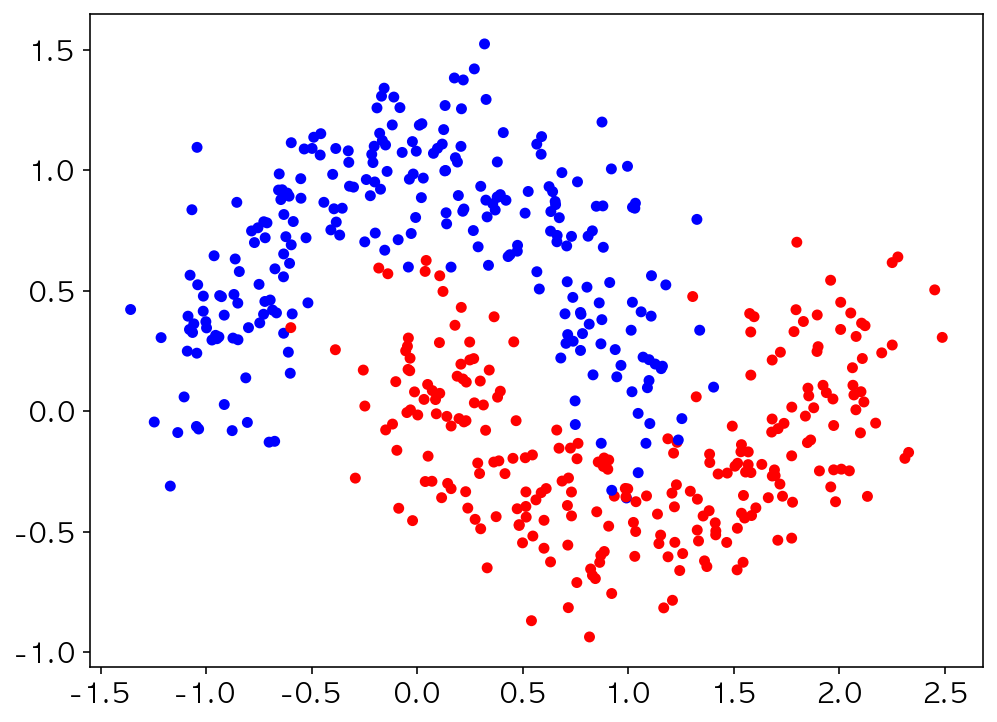

In [38]:
X, y = make_moons(n_samples=500, noise=0.15, random_state=11)
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='bwr')
plt.show()
X, y = make_moons(n_samples=500, noise=0.2, random_state=11)
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='bwr')

0.18 11


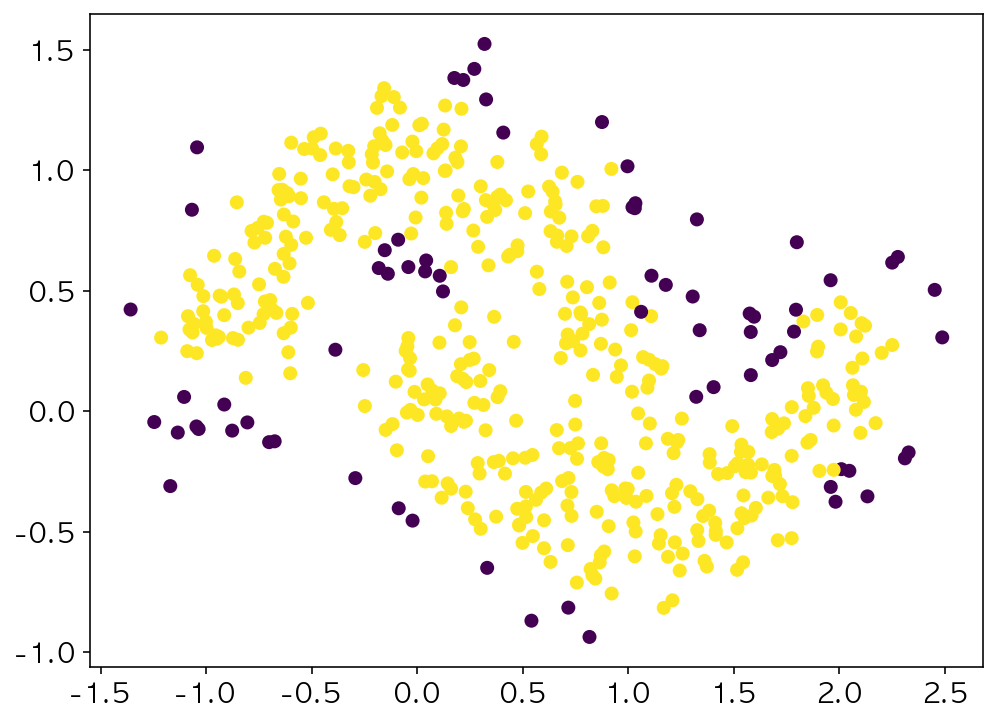

0.18 12


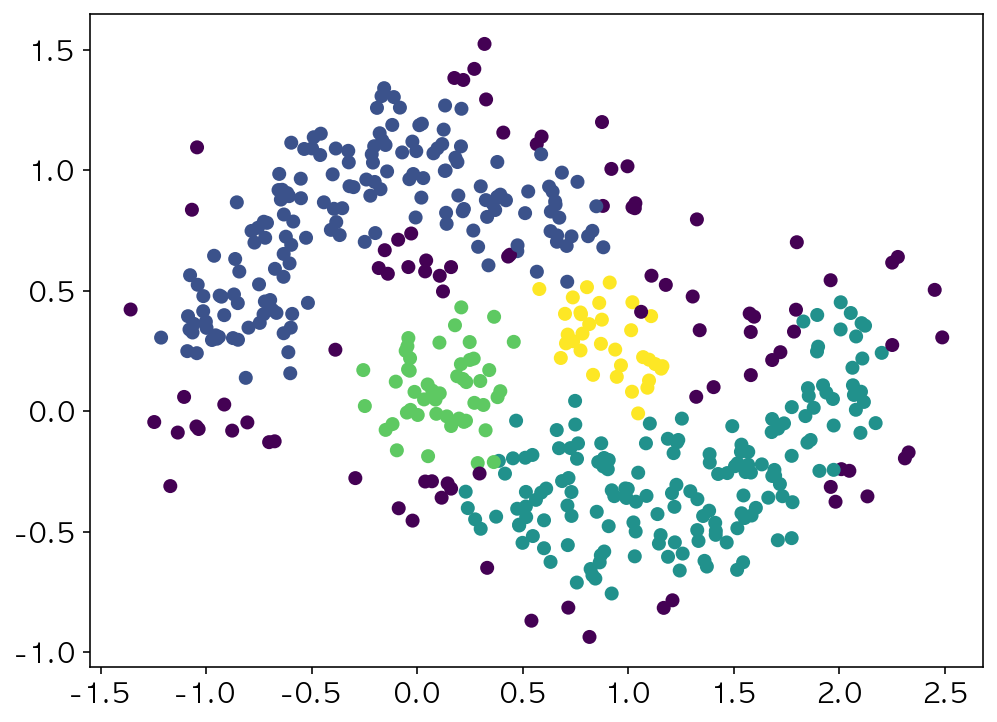

0.18 13


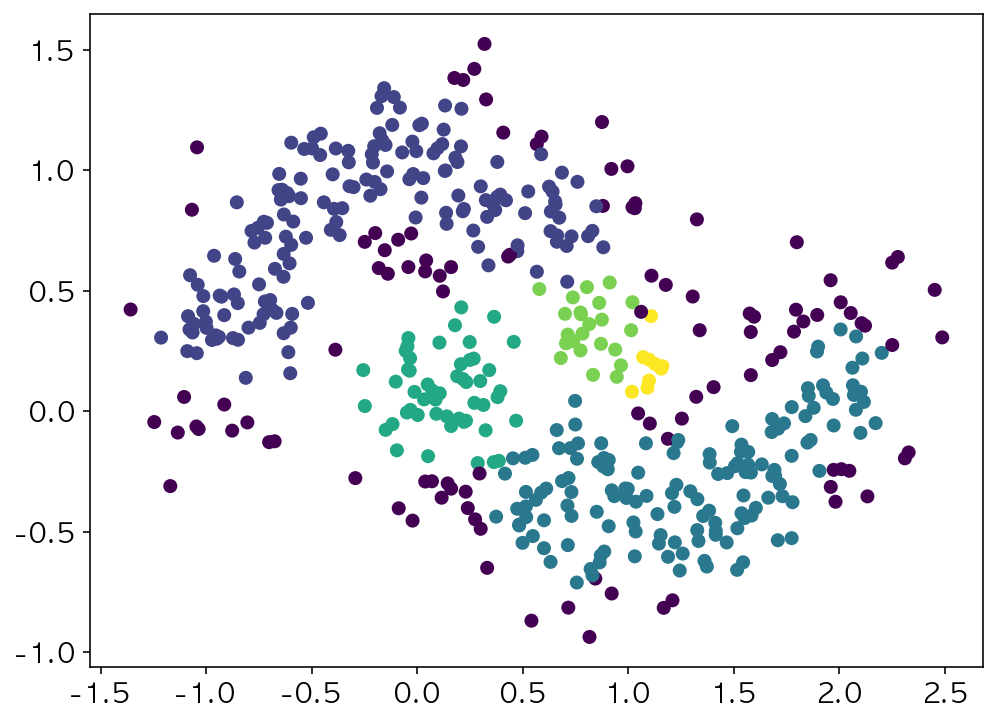

0.19 11


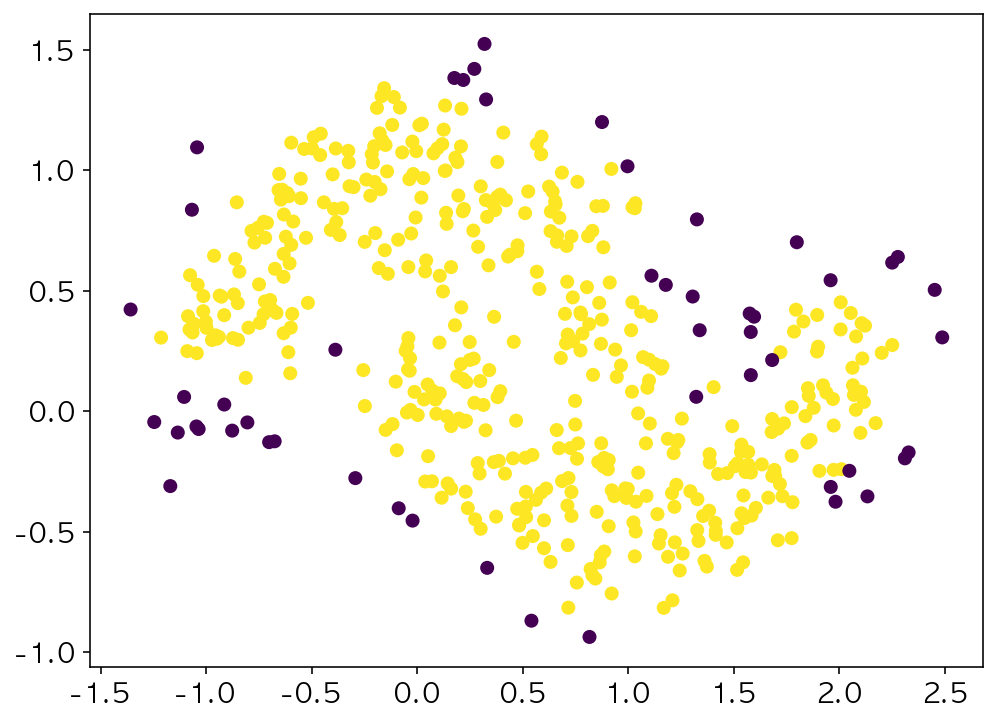

0.19 12


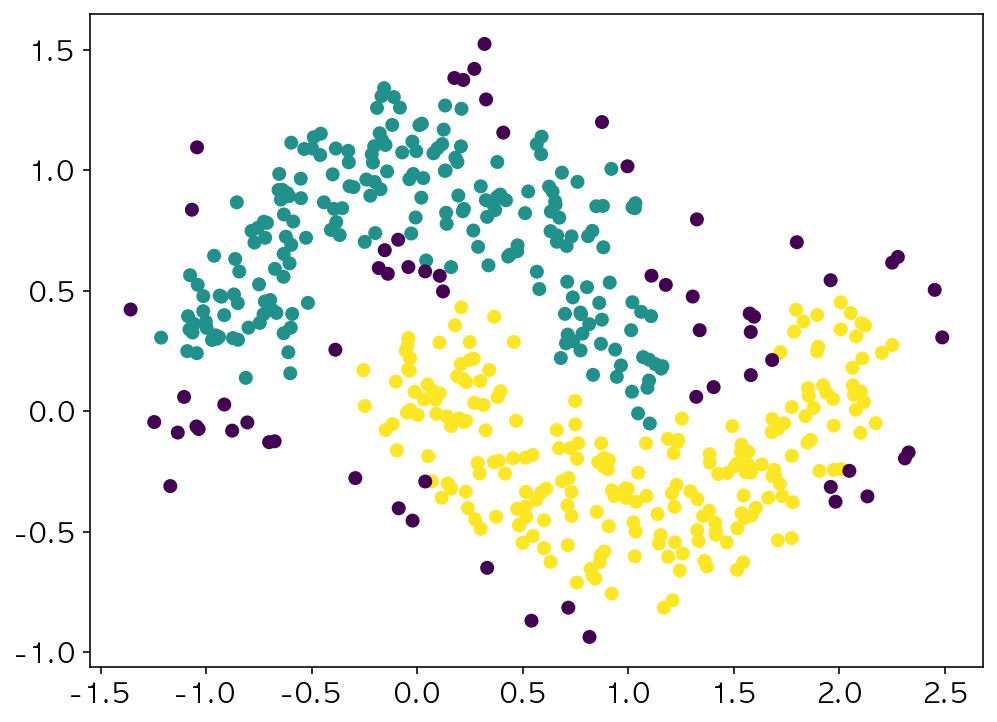

0.19 13


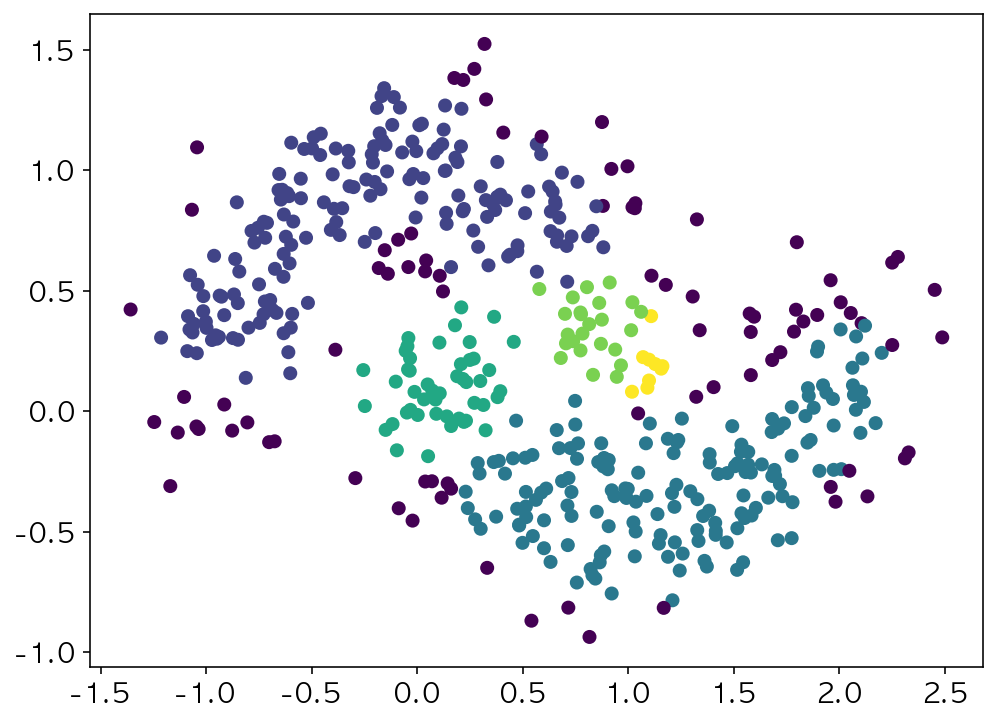

0.2 11


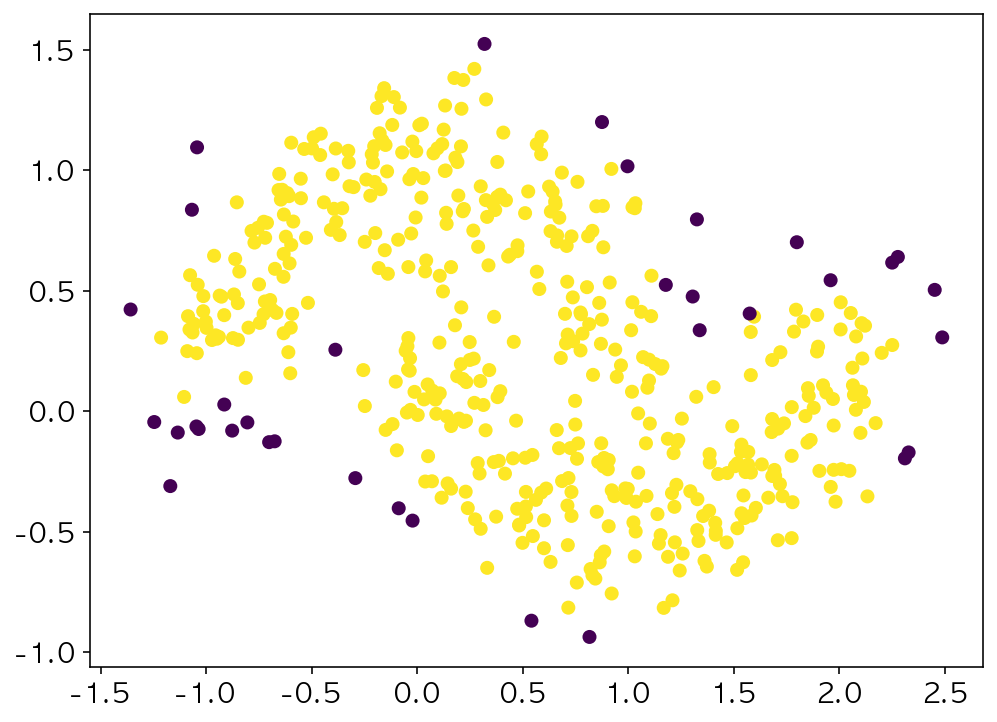

0.2 12


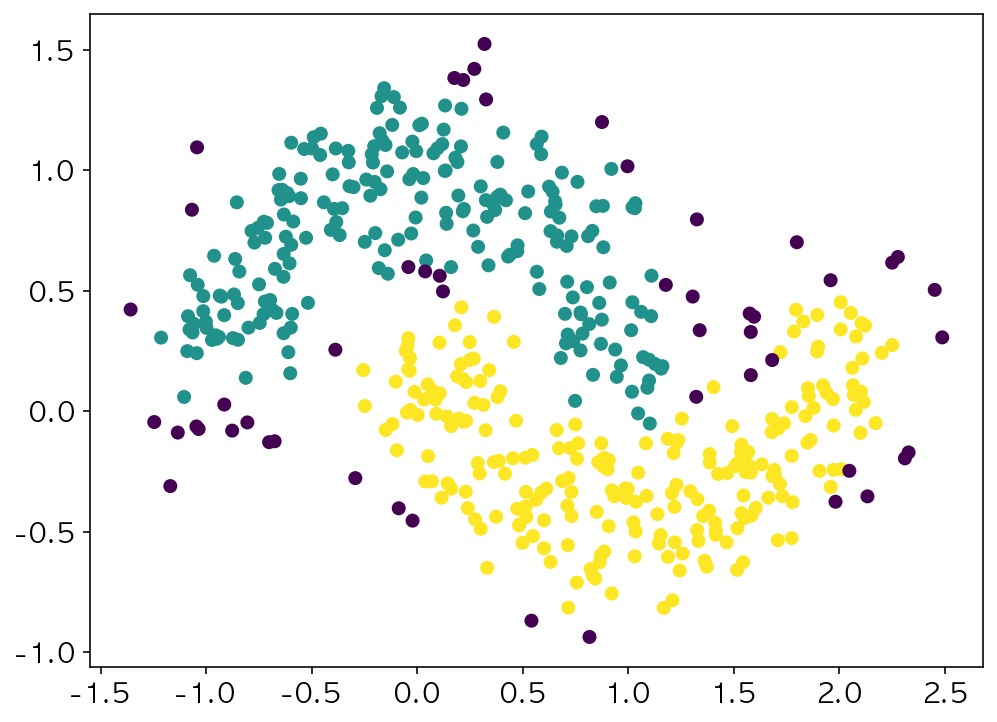

0.2 13


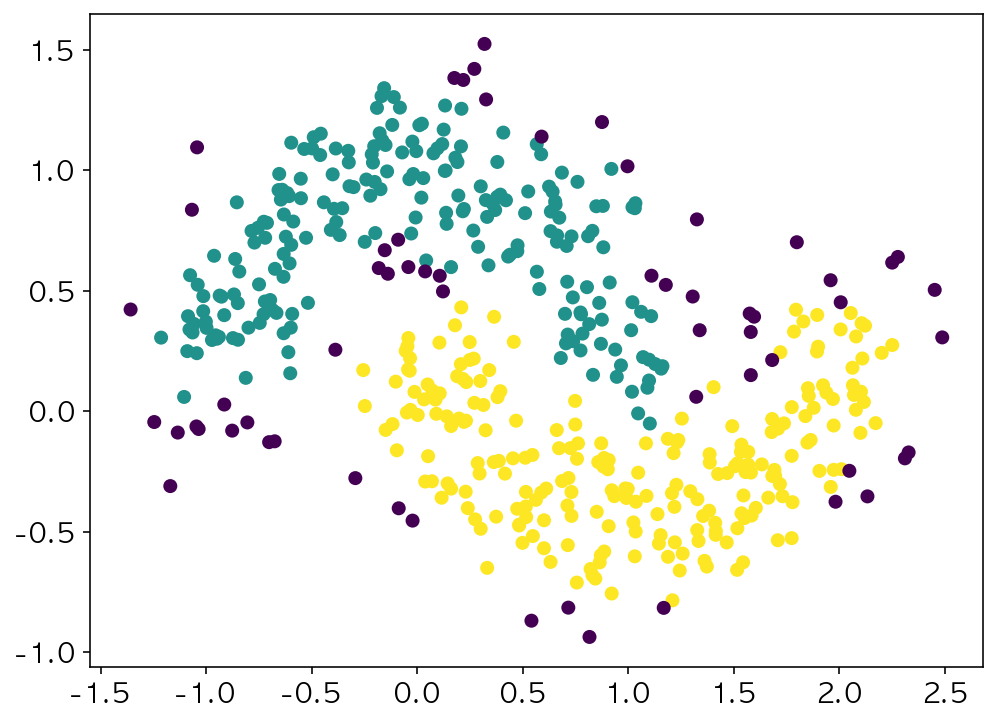

In [39]:
for e in np.arange(0.18,0.21,0.01):
    for m in range (11,14):
        dbscan = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(X)
        print(e, m)
        plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)
        plt.show()

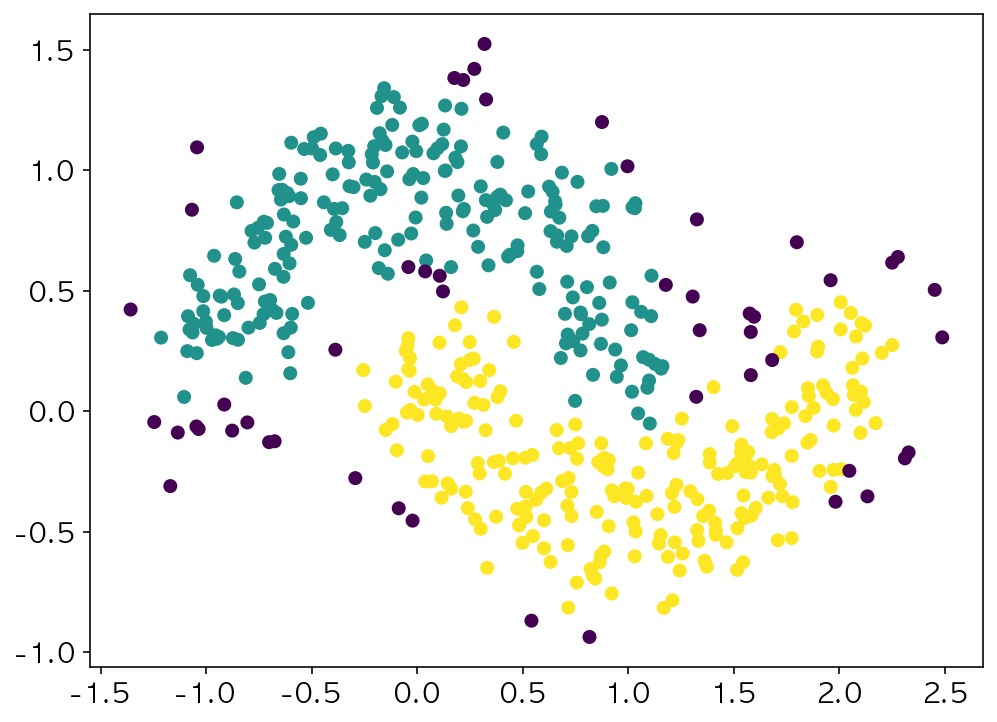

In [40]:
dbscan = DBSCAN(eps=0.2, min_samples=12, metric='euclidean').fit(X)
plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)

# 클러스터링의 predict()
- kMeans 클러스터링 모델은 "예측" 기능을 제공한다
- 특성 공간의 좌표 값을 주면 어느 클러스터에 속할지 가까운 클러스터를 예측해준다

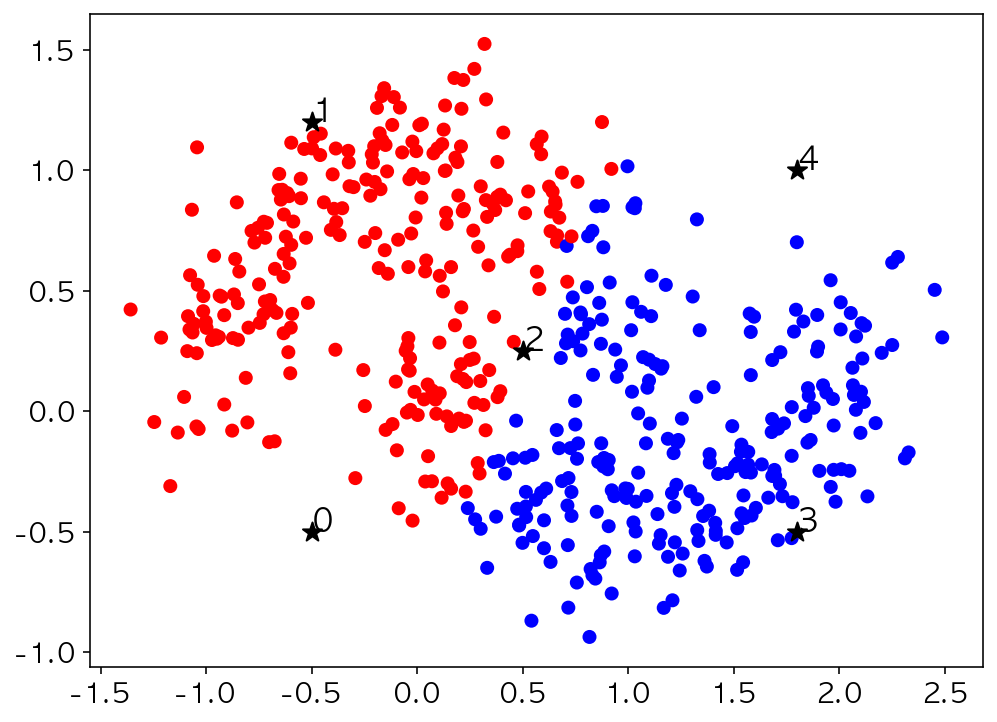

In [41]:
# 임의의 5개 샘플의 좌표 표시
X_samples = np.array([[-0.5,-0.5],  [-0.5,1.2], [0.5,0.25],  [1.8,-0.5],  [1.8,1]])

plt.scatter(X[:,0], X[:,1],c=k.labels_, cmap='bwr')
plt.scatter(X_samples[:,0], X_samples[:,1],c='k',s=100, marker='*')
for i in range(len(X_samples)):
    plt.text(X_samples[:,0][i], X_samples[:,1][i], str(i), fontsize=16)

- 새로운 샘플의 좌표를 주면 예상되는 클러스터 번호를 리턴한다

In [42]:
k.predict(X_samples)

array([1, 1, 1, 0, 0], dtype=int32)

## fit_predict()
- 학습에 사용된 샘플에 대해 학습과 예측을 동시에 수행하는 함수: fit_predict()
- 아래는 색 구분을 k.labels_ 를 출력하는 것이 아니라, 예측한 값을 출력하게 했다

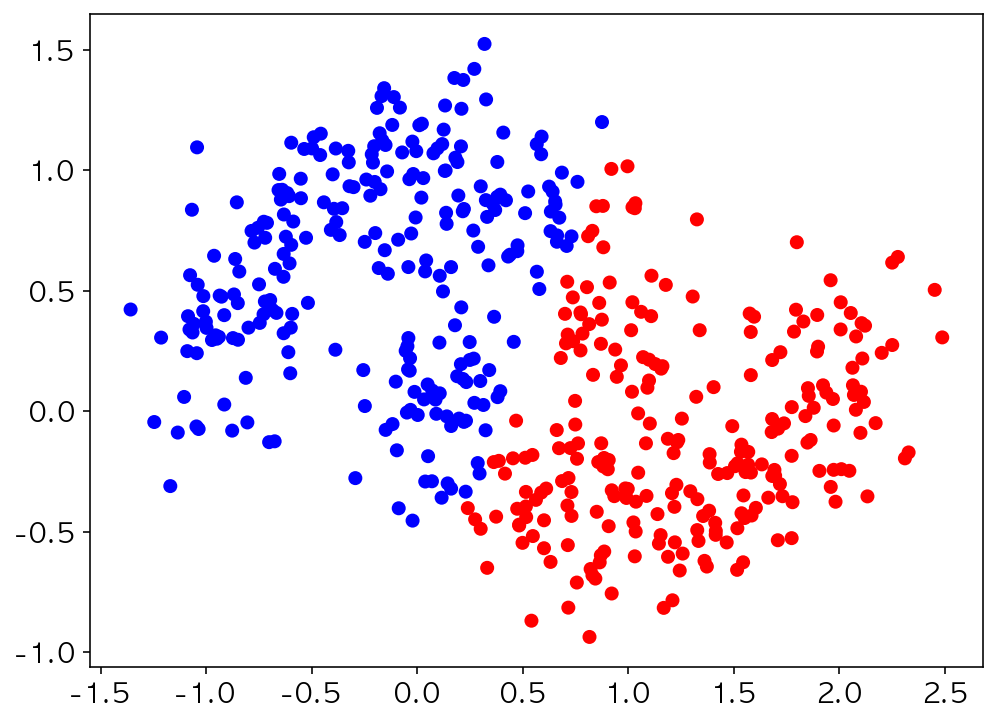

In [43]:
k = KMeans(n_clusters=2)
label_pred = k.fit_predict(X) 
plt.scatter(X[:,0], X[:,1], c = label_pred, cmap='bwr')

# 정답

## (연습) 전력 데이터를 스케일링 한 후 클러스터링 수행
- 표준 스케일링을 적용한 후 클러스터링을 다시 수행하시오

In [44]:
df = power_data.set_index('구분')
df = df.drop(['합계', '개성', '서울','경기'])
df = df[['서비스업', '제조업']]
scaler = StandardScaler()
df.loc[:,['서비스업', '제조업']] = scaler.fit_transform(df.copy()[['서비스업', '제조업']])

<function matplotlib.pyplot.show(close=None, block=None)>

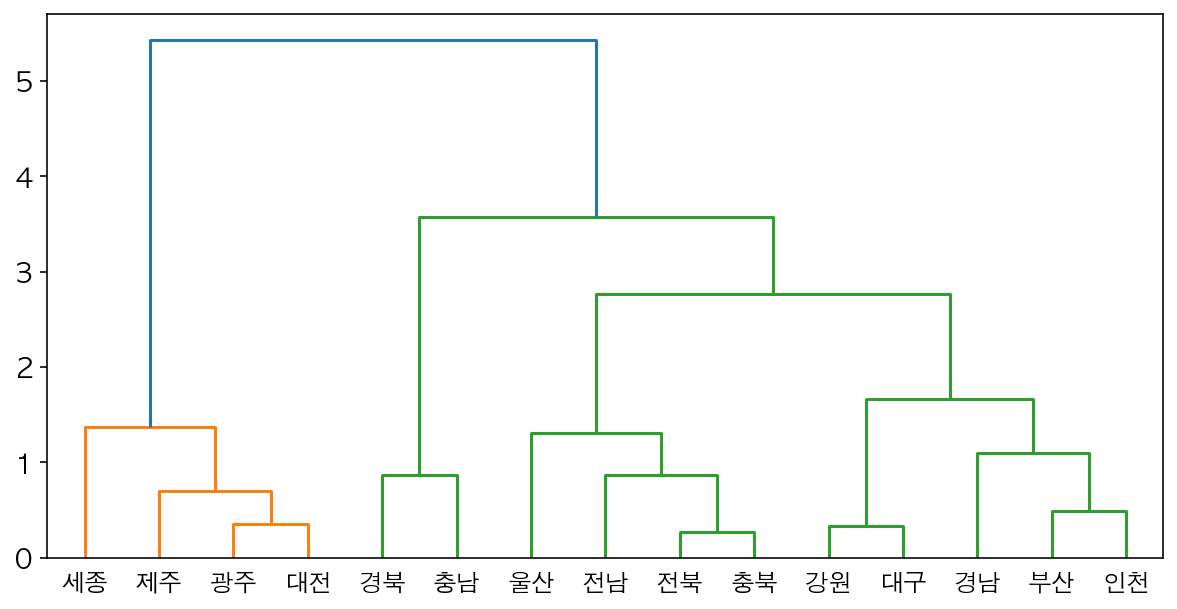

In [45]:
Z = linkage(df, metric='euclidean', method='ward') 
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=df.index.tolist())
plt.show

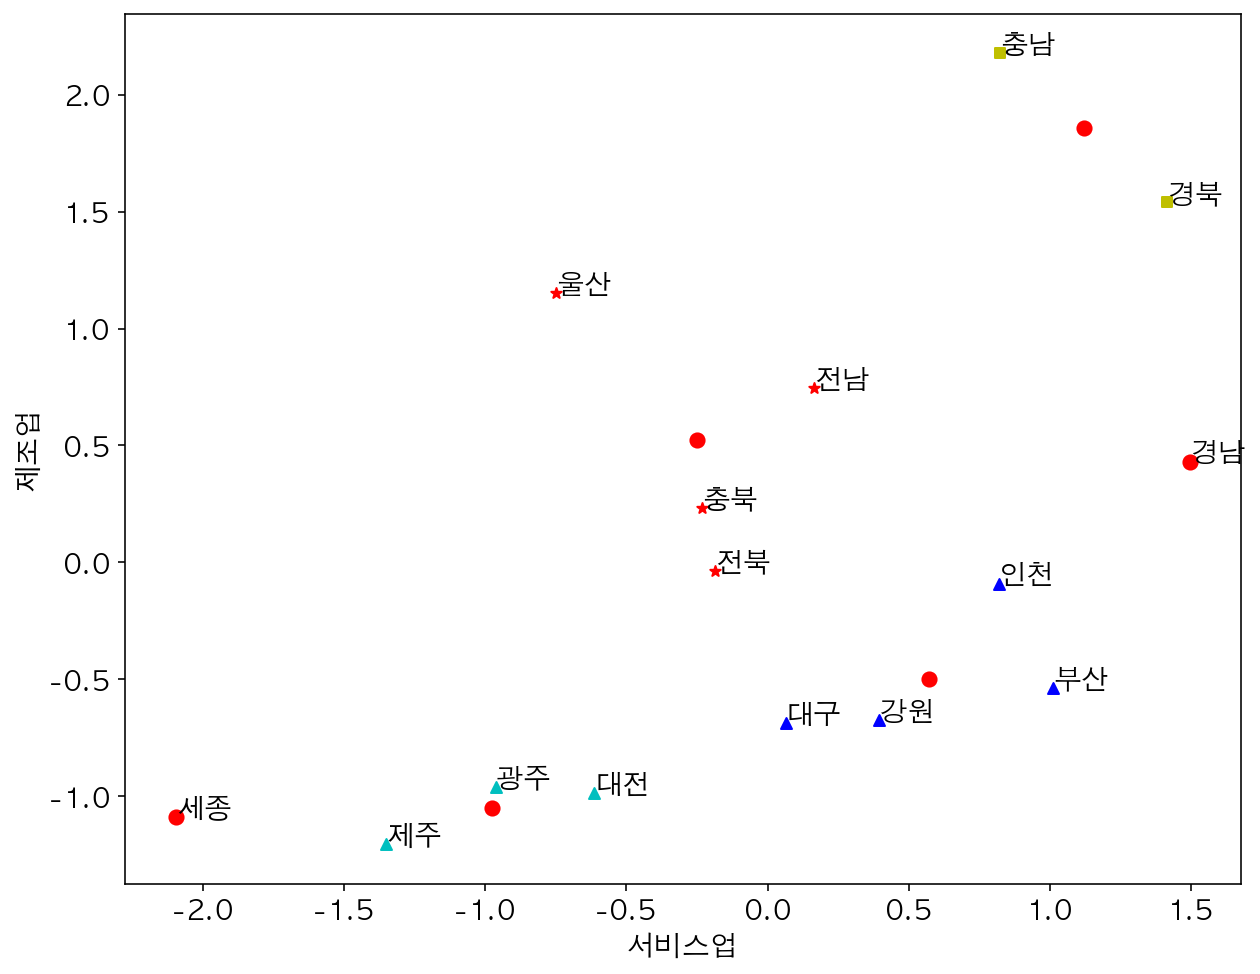

In [46]:
k = KMeans(n_clusters= 6).fit(df)
centers = k.cluster_centers_ 

plt.figure(figsize=(10, 8))
plt.xlabel('서비스업')
plt.ylabel('제조업')

for n in range(df.shape[0]):
    label = k.labels_[n]
    plt.scatter(df['서비스업'][n], df['제조업'][n], c=my_color[label], marker=my_markers[label], s=30)
    plt.text(df['서비스업'][n], df['제조업'][n], df.index[n])
    
for i in range(k.n_clusters):
    plt.scatter(centers[i][0], centers[i][1], c = 'r', s= 50)

## (연습) 서울과 경기를 포함하여 PCA-2 산포도를 그려보시오

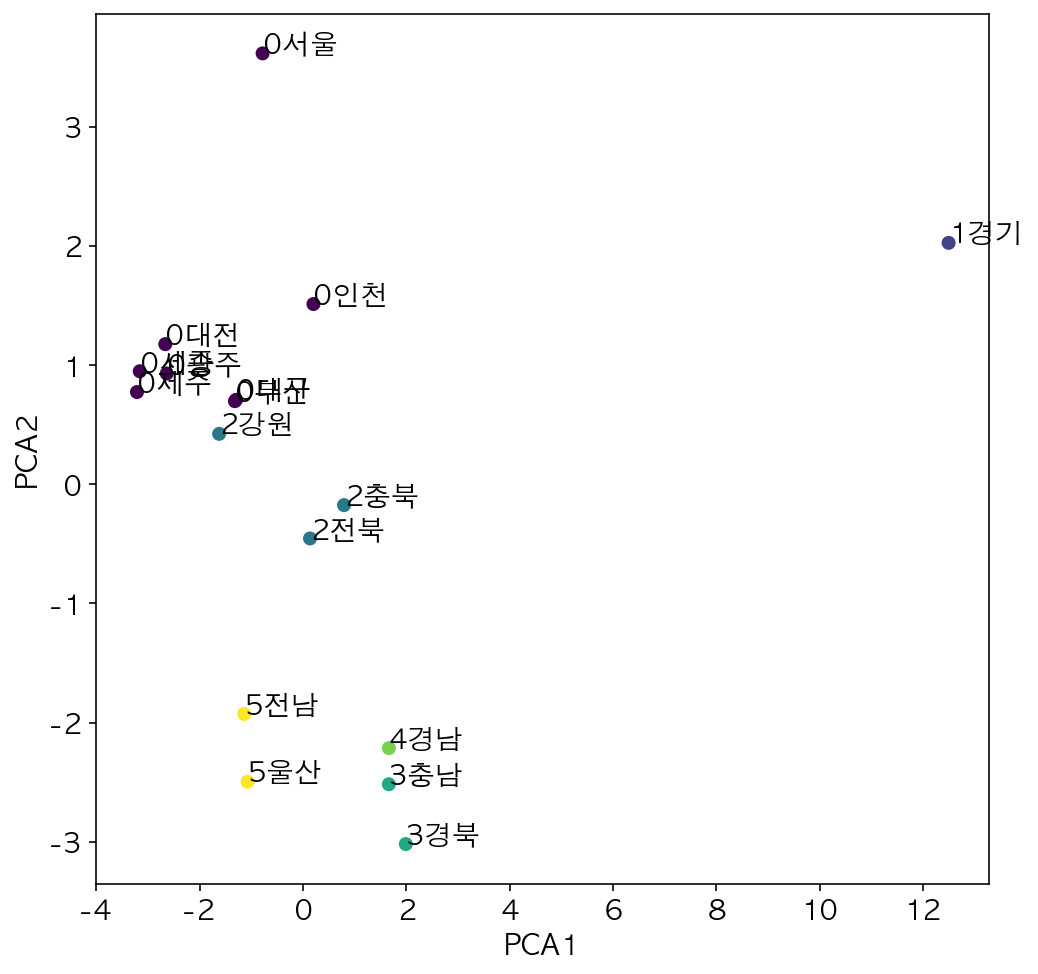

In [47]:
df = power_data.set_index('구분')
df.drop(['업무용합계', '산업용합계', '합계'], axis=1, 
           inplace=True, errors='ignore')
# df.drop(['합계','개성','경기','서울'], inplace=True,errors='ignore')
df.drop(['합계','개성'], inplace=True,errors='ignore')

df_sc = scaler.fit_transform(df)
k = KMeans(n_clusters= 6).fit(df_sc)

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(df_sc)
plt.figure(figsize=(8,8))
plt.scatter(X_pca2[:,0],X_pca2[:,1], c=k.labels_)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
for n in range(df.shape[0]):
    plt.text(X_pca2[:,0][n], X_pca2[:,1][n], str(k.labels_[n])+df.index[n])

## (연습) two_moon 생성시 noise=0.2로 하고 가능한 두개의 클러스터를 찾아보시오
- 노이지가 많으면 클러스터 구분이 어려워진다
- 시행착오 방법으로 최적의 eps과 min_samples 값을 찾는 문제이다.


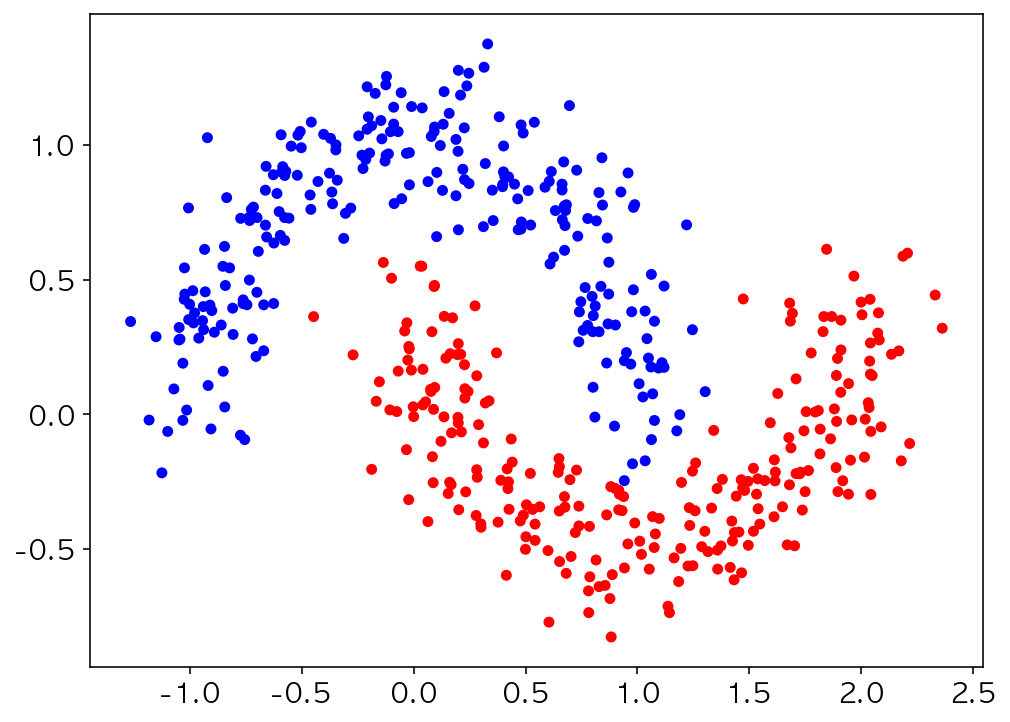

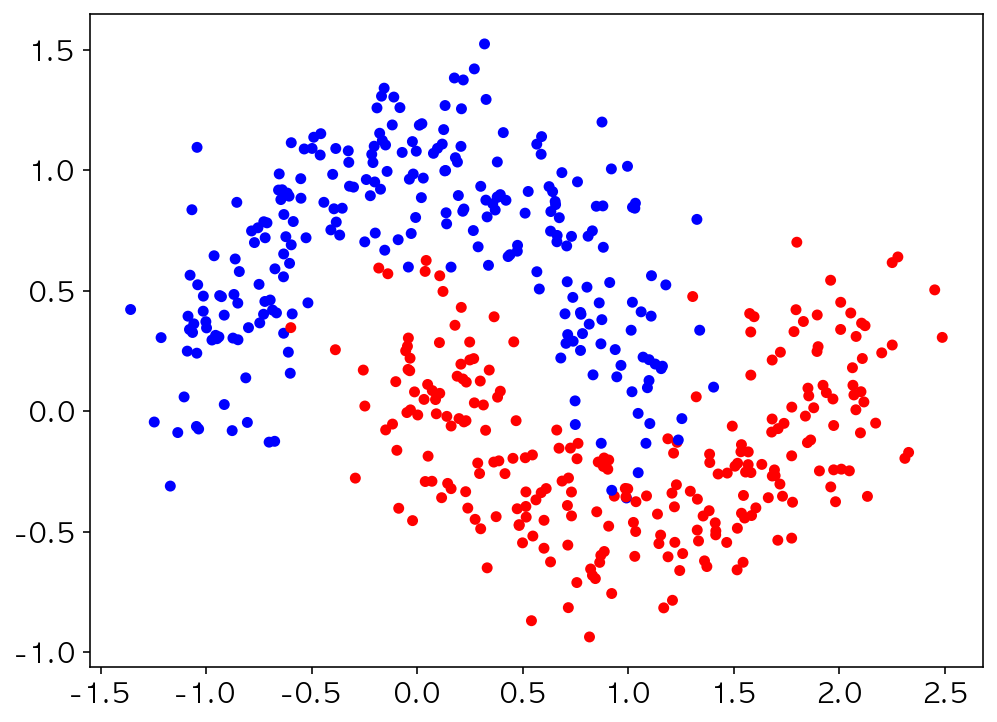

In [48]:
X, y = make_moons(n_samples=500, noise=0.15, random_state=11)
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='bwr')
plt.show()
X, y = make_moons(n_samples=500, noise=0.2, random_state=11)
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='bwr')

0.18 11


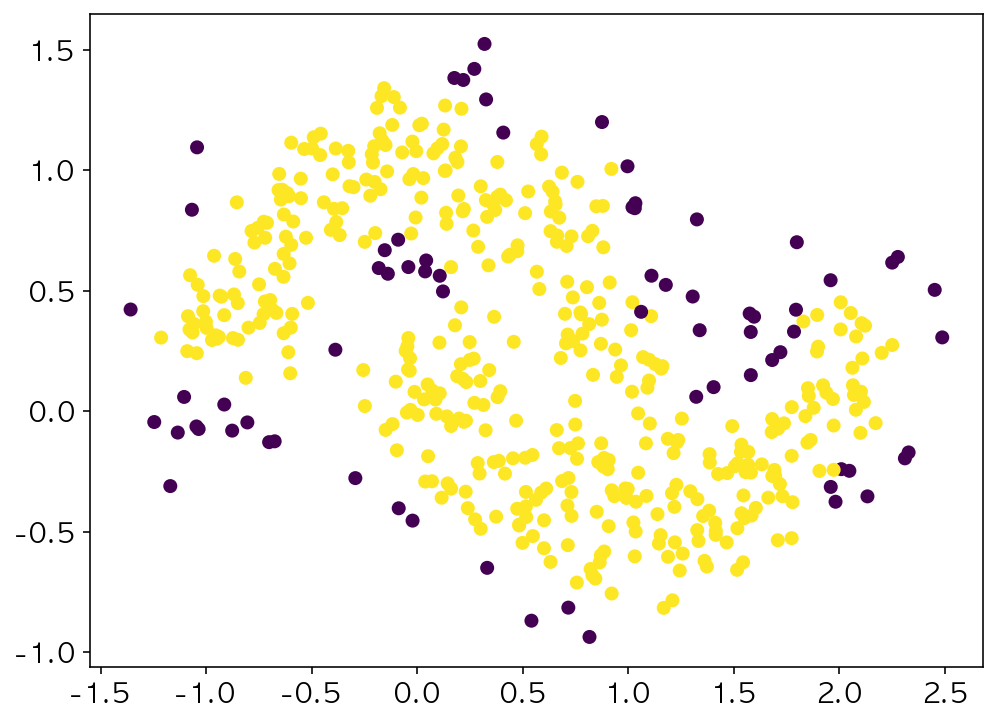

0.18 12


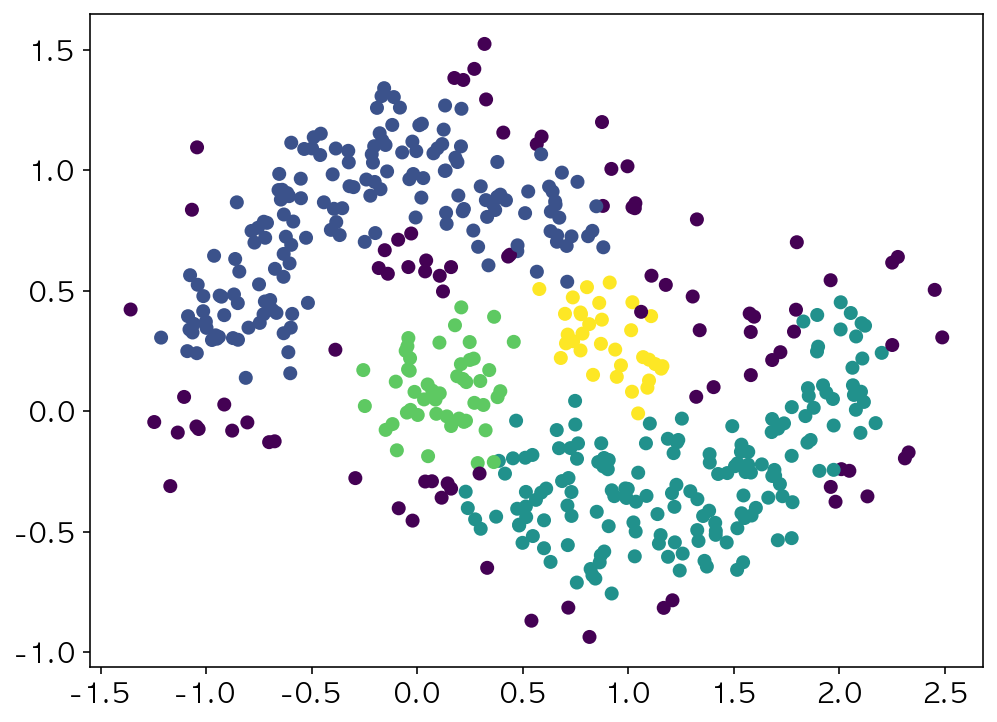

0.18 13


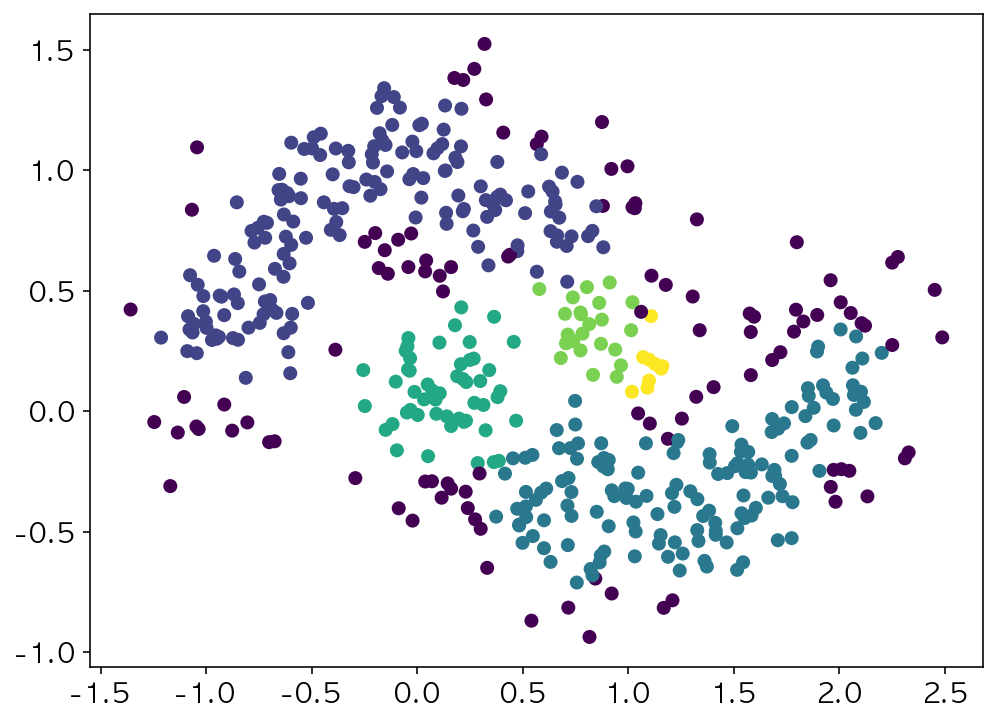

0.19 11


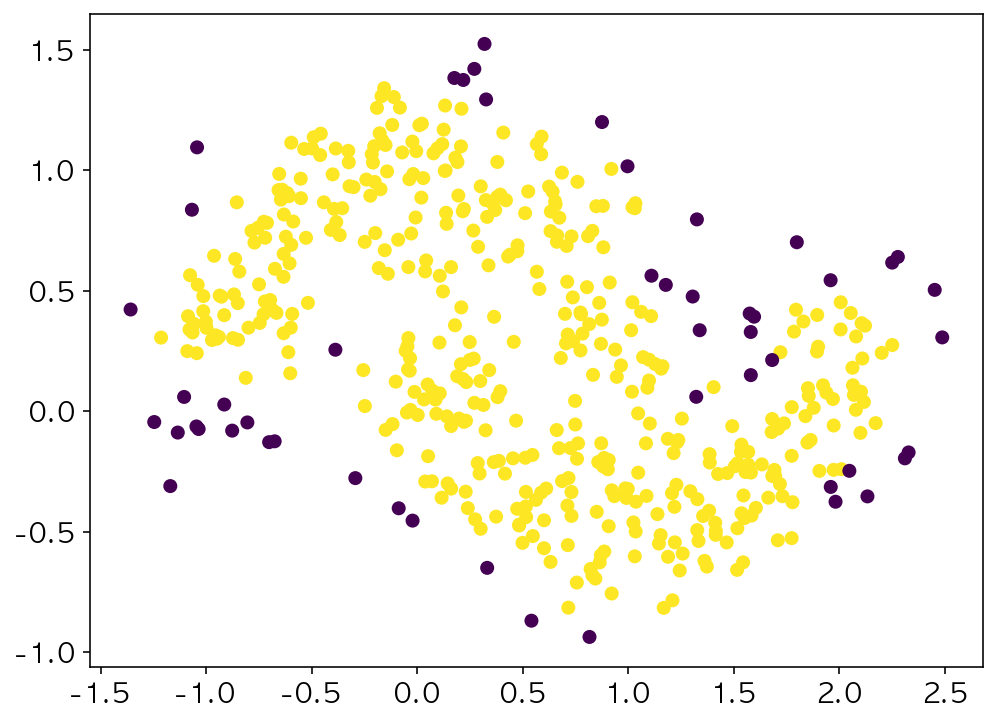

0.19 12


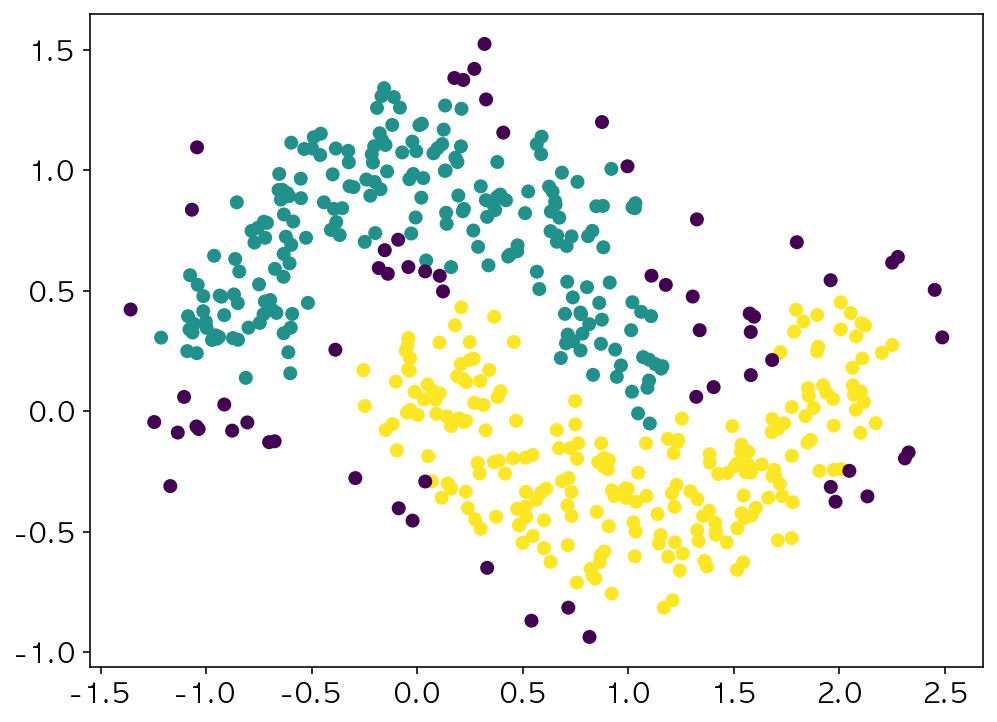

0.19 13


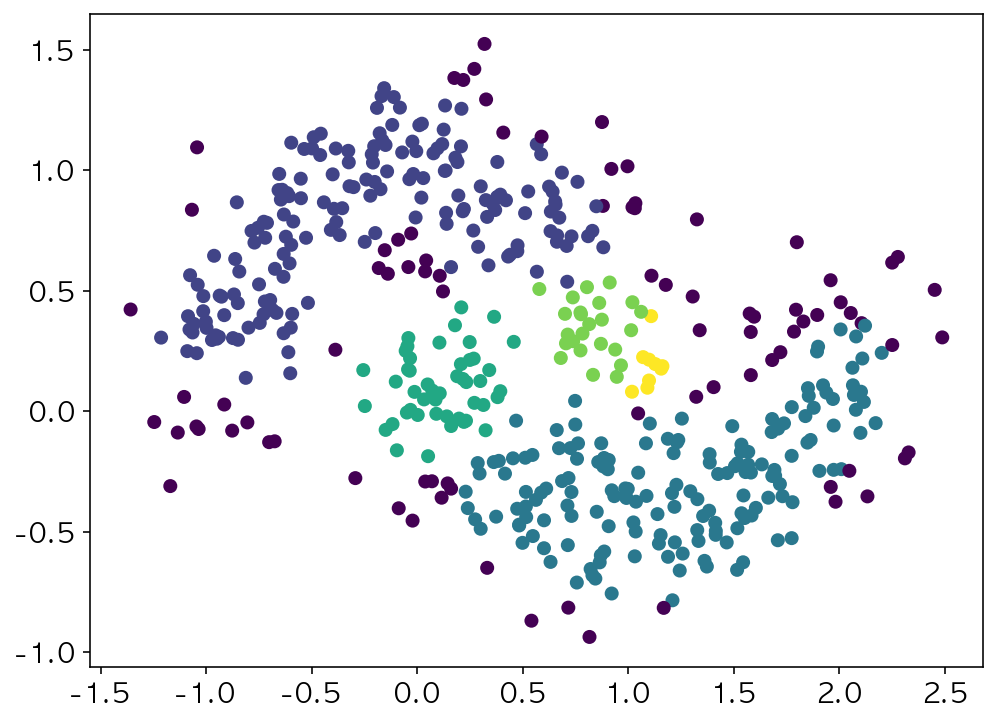

0.2 11


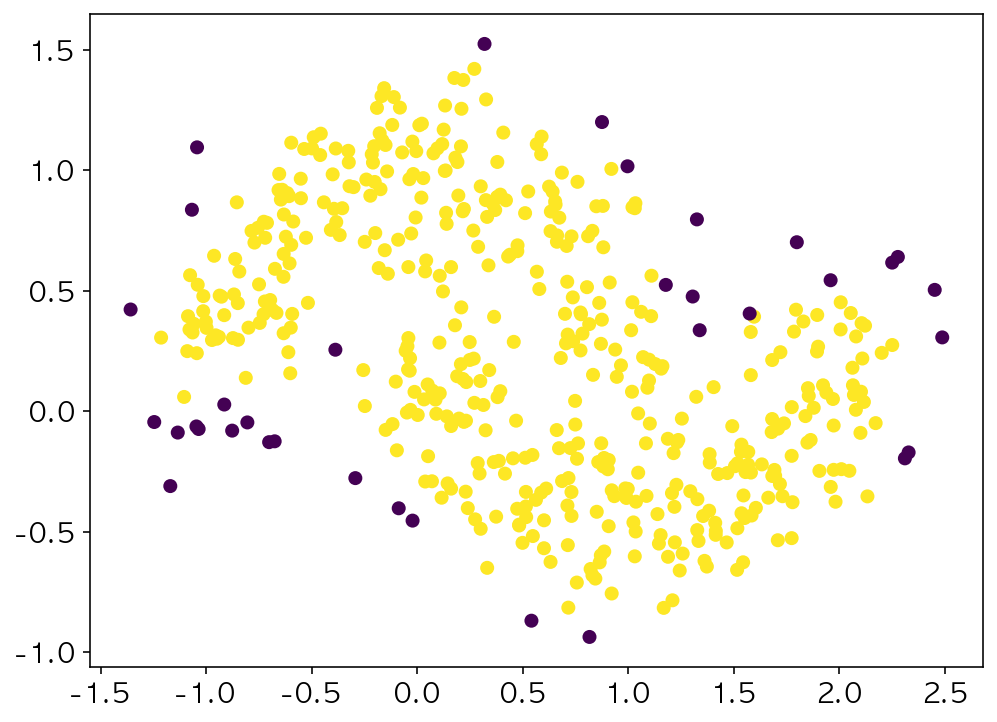

0.2 12


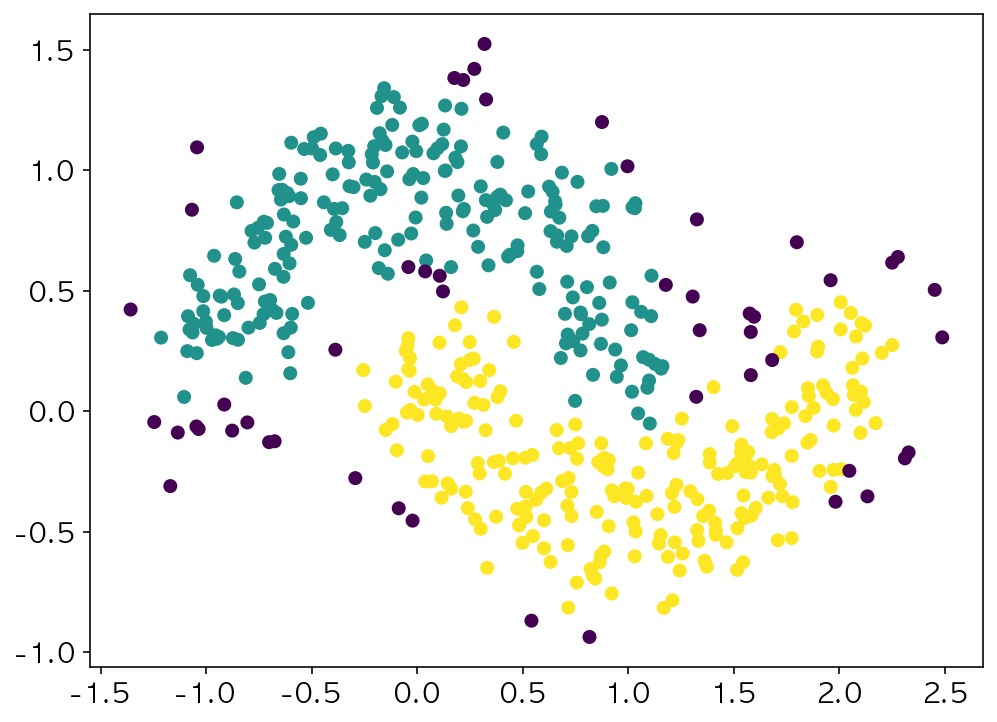

0.2 13


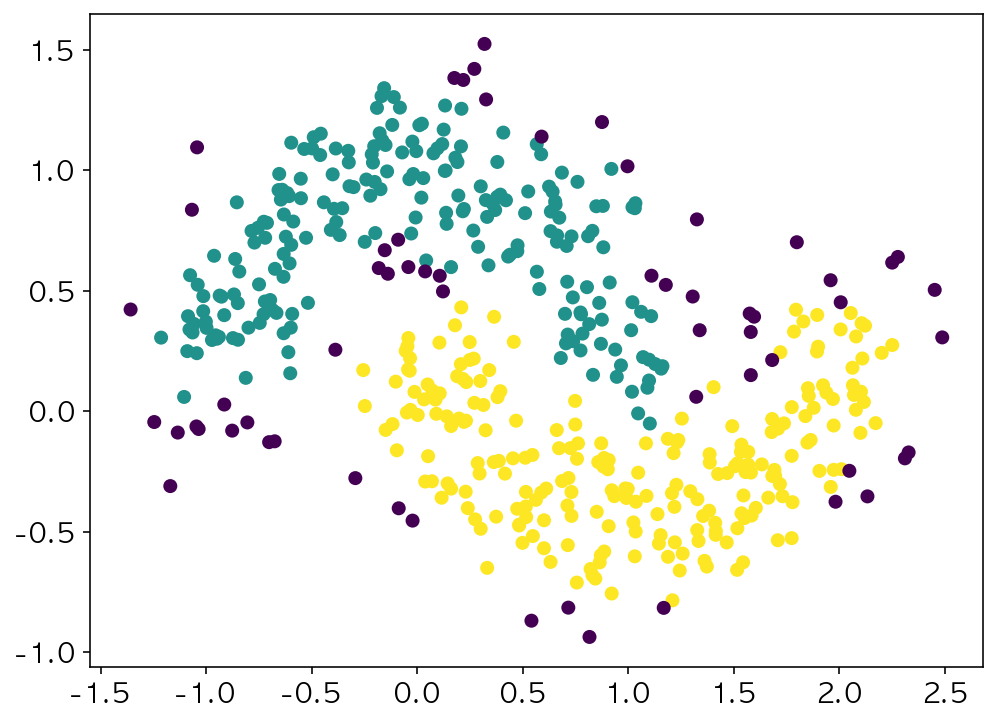

In [49]:
for e in np.arange(0.18,0.21,0.01):
    for m in range (11,14):
        dbscan = DBSCAN(eps=e, min_samples=m, metric='euclidean').fit(X)
        print(e, m)
        plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)
        plt.show()

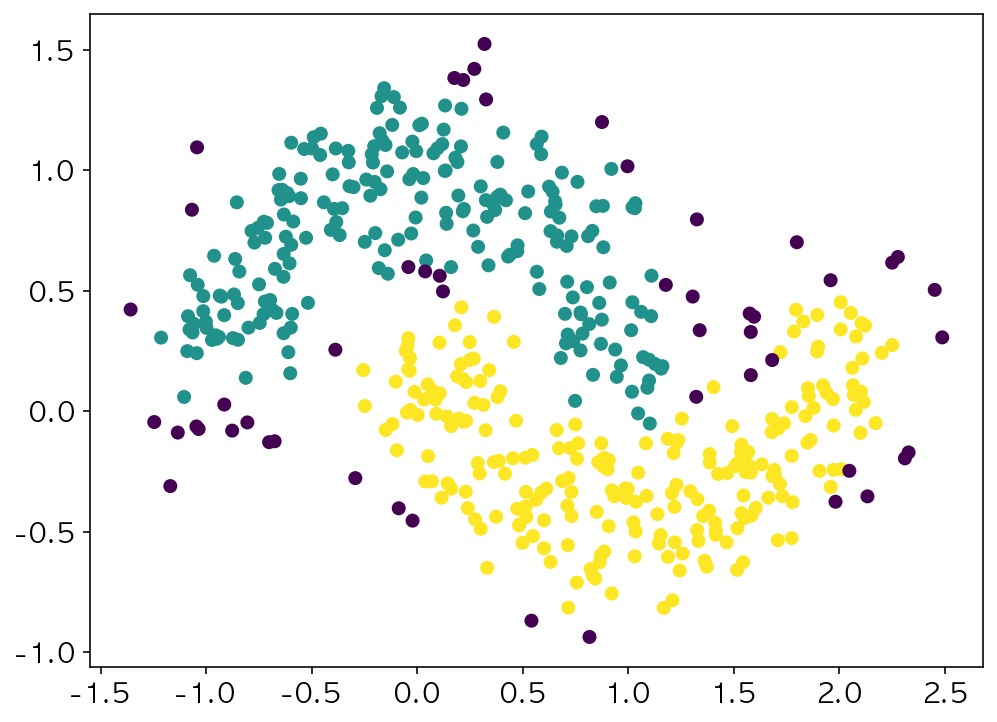

In [50]:
dbscan = DBSCAN(eps=0.2, min_samples=12, metric='euclidean').fit(X)
plt.scatter(X[:,0], X[:,1],c=dbscan.labels_)